In [1]:
import pyhere
import sys
sys.path.insert(0, str(pyhere.here().resolve().joinpath("src")))
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate, validation_curve, learning_curve, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, get_scorer_names, mean_pinball_loss, make_scorer
from sklearn.ensemble import RandomForestRegressor, IsolationForest, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from statsmodels import api as sm
import joblib
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
from mapie.quantile_regression import MapieQuantileRegressor
from pprint import pprint


# FUNCTIONS

In [2]:
# def capacity_factor_formula:
#     hours_year = 8760
#     capacity_factor = generation / (capacity * hours_year)

def validation_curve_plot(plot_title, model, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(
            model,
            X,
            y,
            param_name = param_name,
            param_range = param_range,
            cv = 5
        )
        
    np.mean(train_scores, axis=1)
    
    plt.figure(figsize=(15,5))
    plt.plot(np.mean(train_scores, axis=1),
        label = "Training Score", color = 'b')
    plt.plot(np.mean(test_scores, axis=1),
    label = "Cross Validation Score", color = 'g')
    plt.xticks(np.arange(param_range.shape[0]), param_range)
    plt.title(plot_title)
    plt.legend()

def learning_curve_plot(plot_title, model_with_hp, X, y):
    lc = learning_curve(model_with_hp, X, y, cv=5)
    samples, train, test = lc[0], lc[1], lc[2]
    
    plt.figure(figsize=(15,5))
    plt.plot(samples, np.mean(train, axis=1),
        label = "Training Score", color = 'b')
    plt.plot(samples, np.mean(test, axis=1),
    label = "Cross Validation Score", color = 'g')
    plt.title(plot_title)
    plt.legend()


# def performance_metrics(y_true, y_pred, dataset_type):
def performance_metrics_cross_val(X, y, model_with_hp, dataset_type):
    results = cross_validate(
        model_with_hp,
        X, 
        y, 
        cv=5, 
        scoring=(
            'r2', 
            'neg_mean_squared_error', 
            'neg_mean_absolute_error',
            'neg_root_mean_squared_error')
    )

    dict_results = {}
    for i, val in results.items():
        if 'test' in i:
            if 'neg' in i:
                dict_results[i.replace("neg_", "")] = -np.mean(val)

                # if 'mean_squared_error' in i:
                #     dict_results['test_root_mean_squared_error'] = np.sqrt(-np.mean(val))
            else:
                dict_results[i] = np.mean(val)
    return dict_results
    # cross_val_score(lasso, X, y, cv=5)
    # cross_val_score(nb_model_1, X, y, cv=StratifiedKFold(shuffle = True))
    # r2 = r2_score(y_true, y_pred)
    # mse = mean_squared_error(y_true, y_pred)
    # rmse = np.sqrt(mse) 
    # mae = mean_absolute_error(y_true, y_pred)
    # return pd.DataFrame({'metrica': ['R2', 'MSE', 'RMSE', 'MAE'],
    #                      'valor':[r2, mse, rmse, mae],
    #                      'dataset_type':dataset_type})
                         
    
def coef_summary(results):
    '''
    Toma los resultado del modelo de OLS 
    
    Elimina el intercepto.
    '''
    # Creo un dataframe de los resultados del summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Agrego el nombre de las columnas
    coef_df.columns = coef_df.iloc[0]

    # Elimino la fila extra del intercepto
    coef_df=coef_df.drop(0)

    # Seteo el nombre de las variables como index
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Convertimos a float los object 
    coef_df = coef_df.astype(float)

    # Obtenemos el error; (coef - limite inferior del IC)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Agregamos los errores al dataframe
    coef_df['errors'] = errors

    # Eliminamos la variable const
    coef_df = coef_df.drop(['const'])

    # Ordenamos los coeficientes 
    coef_df = coef_df.sort_values(by=['coef'])

    ### Graficamos ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Agregamos la columna con el nombre de las variables
    coef_df['variables'] = variables
   
    return  coef_df

    
def adjusted_r2(X, y_true, y_pred):   
    print((1-(1-r2_score(y_true, y_pred))*((len(X)-1))/(len(X)-len(X.columns)-1)))

def generate_results_dataset(preds, ci):
    df = pd.DataFrame()
    df['prediction'] = preds
    if ci >= 0:
        df['upper'] = preds + ci
        df['lower'] = preds - ci
    else:
        df['upper'] = preds - ci
        df['lower'] = preds + ci
        
    return df

# DATAFRAMES

primary_fuel_transformed
Other                       18917
Solar                       10665
Wind                         5344
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

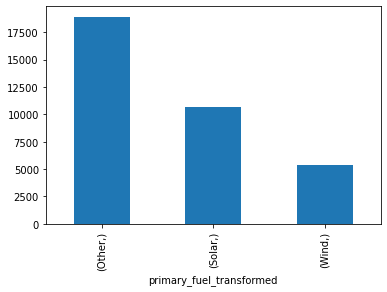

In [3]:
csv_power_plants = pd.read_csv(utils.DIR_DATA_INTERIM/"power_plants_with_generation_transformed.csv", index_col=[0])
# df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v2_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v5_transformed_data_combined_with_nasa.csv", index_col=['index'])
# csv_power_plants.loc[0:34935, ['capacity_mw', 'primary_fuel_transformed']].index.name = "index"
csv_power_plants.index.rename('index', inplace=True)
df_power_plants_raw = pd.read_csv(utils.DIR_DATA_RAW/"global_power_plant_database.csv", usecols=['name','primary_fuel', 'estimated_generation_gwh_2013'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

# index_set_to_delete = csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])].index.tolist()
# index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])].index.tolist())
# index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])].index.tolist())

# csv_power_plants.drop(index_set_to_delete, inplace = True)
columns_to_combine = [
                        'name',
                        'capacity_mw',
                        'primary_fuel_transformed',
                        # 'other_fuel1',
                        # 'other_fuel2',
                        # 'other_fuel3',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        # 'estimated_generation_gwh_2013',
                        # 'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:24360, ['capacity_mw', 'primary_fuel_transformed']],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [4]:
df_solar = df_transformed_combined[df_transformed_combined['primary_fuel_transformed']== "Solar"]
df_solar = df_solar[~df_solar['name'].str.contains('CSP')]
df_solar

,latitude,longitude,ANN_ALLSKY_SFC_LW_DWN_2013,ANN_ALLSKY_SFC_LW_DWN_2014,ANN_ALLSKY_SFC_LW_DWN_2015,ANN_ALLSKY_SFC_LW_DWN_2016,ANN_ALLSKY_SFC_LW_DWN_2017,ANN_ALLSKY_SFC_LW_DWN_2018,ANN_ALLSKY_SFC_LW_DWN_2019,ANN_ALLSKY_SFC_LW_UP_2013,...,winter_WS50M_RANGE_AVG_2019,name,capacity_mw,primary_fuel_transformed,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018
index,,,,,,,,,,,,,,,,,,,,,
1,31.670,65.795,315.48,312.10,318.59,312.91,312.98,315.31,315.80,10.41,...,6.300000,Kandahar DOG,10.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
2,31.623,65.792,315.48,312.10,318.59,312.91,312.98,315.31,315.80,10.41,...,6.300000,Kandahar JOL,10.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
17,27.908,-0.317,355.96,359.55,360.83,361.69,359.83,358.59,353.05,11.13,...,5.710000,Adrar,20.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
18,35.880,5.475,323.29,325.23,325.22,326.49,323.06,322.57,322.19,9.84,...,4.913333,Ain Azel,20.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
20,34.532,0.804,317.57,321.81,321.93,323.80,323.66,318.45,315.98,9.62,...,5.453333,Ain Sekhouna,20.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34833,11.700,108.900,385.23,383.91,383.59,389.36,389.60,388.57,386.47,10.55,...,2.240000,Ninh Thuận CMX,168.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
34847,11.446,108.866,385.23,383.91,383.59,389.36,389.60,388.57,386.47,10.55,...,2.240000,Phước Nam,330.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN
34894,16.440,107.505,419.30,417.81,417.75,423.10,418.65,417.83,421.23,10.82,...,2.940000,Thua Thien Hue TTC,48.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# df_solar_attempt = df_solar[df_solar['generation_gwh_2013'].isna() & df_solar['estimated_generation_gwh_2013'].notna()]
# # df_solar_attempt.loc[:,['generation_gwh_2013']] = 23.23
# # df_solar_attempt.loc[:,['generation_gwh_2013']] = df_solar_attempt.loc[:,['estimated_generation_gwh_2013']].copy()
# df_solar.loc[df_solar_attempt.index, ['generation_gwh_2013']] = df_solar_attempt.loc[:,['estimated_generation_gwh_2013']]

# df_solar['generation_gwh_2013'].fillna(df_solar['estimated_generation_gwh_2013'], inplace=True)

# # df_solar[df_solar['generation_gwh_2013'].isna()]

In [6]:
# df_solar_alt = df_solar[df_solar['generation_gwh_2013'].notna()]
# df_solar_alt['generation_gwh_2013'].value_counts().hist(bins=10)
# print(df_solar_alt[df_solar_alt['generation_gwh_2013'] < 20]['generation_gwh_2013'].count())
# print(df_solar_alt.loc[(df_solar_alt['generation_gwh_2013'] >= 20) & (df_solar_alt['generation_gwh_2013'] < 100)]['generation_gwh_2013'].count())


In [7]:

# df_solar_alt.loc[df_solar_alt['capacity_mw'] == (df_solar_alt['capacity_mw'].value_counts()>20)]
# indexes = df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()>20).index
# df_solar_alt['capacity_mw'].value_counts().values>20
# df_solar_alt.loc[indexes]['capacity_mw']
# df_solar_alt[df_solar_alt['capacity_mw'] == 145]
# df_solar_alt[df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()[df_solar_alt['capacity_mw'].value_counts()>20].index)].capacity_mw
# df_solar_alt_more_than_20 = df_solar_alt[df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()[df_solar_alt['capacity_mw'].value_counts()>20].index)]
# df_solar_alt_more_than_20['capacity_mw'].hist()

In [8]:
# utils.calculate_feature_mean_std(df_solar_alt)

In [9]:
df_solar_2013 = df_solar[df_solar['generation_gwh_2013'].notna()]
df_solar_2014 = df_solar[df_solar['generation_gwh_2014'].notna()]
df_solar_2015 = df_solar[df_solar['generation_gwh_2015'].notna()]
df_solar_2016 = df_solar[df_solar['generation_gwh_2016'].notna()]
df_solar_2017 = df_solar[df_solar['generation_gwh_2017'].notna()]
df_solar_2018 = df_solar[df_solar['generation_gwh_2018'].notna()]
# columns_delete = df_solar.columns.str.contains('WS') | df_solar.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2013') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') |  df_solar.columns.str.contains('ANN') |  df_solar.columns.str.contains('LW') |  df_solar.columns.str.contains('WS10') | df_solar.columns.str.contains('MAX')
# columns_delete = df_solar_alt.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2013') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') 
# columns_delete = df_solar_alt.columns.str.contains('2013') | df_solar_alt.columns.str.contains('generation_gwh_2013') | df_solar_alt.columns.str.contains('estimated_generation_gwh_2013') | df_solar_alt.columns.str.contains('WS') | df_solar_alt.columns.str.contains('name') | df_solar_alt.columns.str.contains('primary_fuel_transformed') | df_solar_alt.columns.str.contains('latitude') | df_solar_alt.columns.str.contains('longitude') | df_solar_alt.columns.str.contains('2019') | df_solar_alt.columns.str.contains('2012') | df_solar_alt.columns.str.contains('2014') | df_solar_alt.columns.str.contains('2015') | df_solar_alt.columns.str.contains('2016') | df_solar_alt.columns.str.contains('2017') | df_solar_alt.columns.str.contains('2018') 
columns_keep_2013 = df_solar_2013.columns.str.contains('2013') | df_solar_2013.columns.str.contains('capacity_mw')
columns_keep_2014 = df_solar_2014.columns.str.contains('2014') | df_solar_2014.columns.str.contains('capacity_mw')
columns_keep_2015 = df_solar_2015.columns.str.contains('2015') | df_solar_2015.columns.str.contains('capacity_mw')
columns_keep_2016 = df_solar_2016.columns.str.contains('2016') | df_solar_2016.columns.str.contains('capacity_mw')
columns_keep_2017 = df_solar_2017.columns.str.contains('2017') | df_solar_2017.columns.str.contains('capacity_mw')
columns_keep_2018 = df_solar_2018.columns.str.contains('2018') | df_solar_2018.columns.str.contains('capacity_mw')
# df_solar_2 = df_solar_alt_more_than_20.loc[:,~columns_delete]
# df_solar_2013 = df_solar_alt.loc[:,~columns_delete]
df_solar_2013 = df_solar_2013.loc[:,columns_keep_2013]
df_solar_2014 = df_solar_2014.loc[:,columns_keep_2014]
df_solar_2015 = df_solar_2015.loc[:,columns_keep_2015]
df_solar_2016 = df_solar_2016.loc[:,columns_keep_2016]
df_solar_2017 = df_solar_2017.loc[:,columns_keep_2017]
df_solar_2018 = df_solar_2018.loc[:,columns_keep_2018]
# columns_delete_2013 = df_solar_2013.columns.str.contains('WS')
df_solar_2013 = df_solar_2013.loc[:,~df_solar_2013.columns.str.contains('WS')]
df_solar_2014 = df_solar_2014.loc[:,~df_solar_2014.columns.str.contains('WS')]
df_solar_2015 = df_solar_2015.loc[:,~df_solar_2015.columns.str.contains('WS')]
df_solar_2016 = df_solar_2016.loc[:,~df_solar_2016.columns.str.contains('WS')]
df_solar_2017 = df_solar_2017.loc[:,~df_solar_2017.columns.str.contains('WS')]
df_solar_2018 = df_solar_2018.loc[:,~df_solar_2018.columns.str.contains('WS')]

In [10]:
dict_columns_2013 = {a:a.replace('_2013', '') for a in df_solar_2013.columns}
dict_columns_2014 = {a:a.replace('_2014', '') for a in df_solar_2014.columns}
dict_columns_2015 = {a:a.replace('_2015', '') for a in df_solar_2015.columns}
dict_columns_2016 = {a:a.replace('_2016', '') for a in df_solar_2016.columns}
dict_columns_2017 = {a:a.replace('_2017', '') for a in df_solar_2017.columns}
dict_columns_2018 = {a:a.replace('_2018', '') for a in df_solar_2018.columns}
df_solar_2013.rename(columns=dict_columns_2013, inplace=True)
df_solar_2014.rename(columns=dict_columns_2014, inplace=True)
df_solar_2015.rename(columns=dict_columns_2015, inplace=True)
df_solar_2016.rename(columns=dict_columns_2016, inplace=True)
df_solar_2017.rename(columns=dict_columns_2017, inplace=True)
df_solar_2018.rename(columns=dict_columns_2018, inplace=True)

In [11]:
df_solar_2018.describe()

,ANN_ALLSKY_SFC_LW_DWN,ANN_ALLSKY_SFC_LW_UP,ANN_ALLSKY_SFC_SW_DIFF,ANN_ALLSKY_SFC_SW_DNI,ANN_ALLSKY_SFC_SW_DWN,ANN_ALLSKY_SFC_SW_UP,ANN_ALLSKY_SFC_SW_UP_MAX,ANN_CLRSKY_SFC_SW_DIFF,ANN_CLRSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DWN,...,winter_ALLSKY_SFC_SW_DWN,winter_ALLSKY_SFC_SW_UP,winter_ALLSKY_SFC_SW_UP_MAX,winter_CLRSKY_SFC_SW_DIFF,winter_CLRSKY_SFC_SW_DNI,winter_CLRSKY_SFC_SW_DWN,winter_CLRSKY_SFC_SW_UP,winter_T2M,capacity_mw,generation_gwh
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,...,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,324.622382,9.271490,1.574338,5.169989,4.542576,0.695442,1.643908,1.211200,8.059989,5.754826,...,5.795841,0.840267,1.129303,1.622546,8.182806,6.971598,1.001426,24.363380,11.987523,23.438099
std,21.203085,0.628932,0.196561,1.504993,0.771645,0.248105,0.777382,0.204655,0.864580,0.389718,...,0.827602,0.288128,0.302026,0.264712,0.959337,0.348129,0.262062,3.266324,32.136923,75.146772
min,256.220000,7.960000,1.160000,2.860000,3.440000,0.160000,0.340000,0.780000,6.800000,5.160000,...,4.620000,0.200000,0.273333,0.940000,6.720000,6.460000,0.246667,12.443333,1.000000,0.000000
25%,309.860000,8.800000,1.470000,3.980000,3.780000,0.510000,1.240000,0.950000,7.480000,5.350000,...,5.083333,0.676667,0.970000,1.313333,7.513333,6.663333,0.860000,21.900000,1.800000,2.098000
50%,323.040000,9.300000,1.630000,4.650000,4.440000,0.620000,1.460000,1.270000,7.630000,5.770000,...,5.540000,0.743333,1.060000,1.733333,7.780000,6.890000,0.950000,24.366667,3.500000,4.541000
75%,340.230000,9.730000,1.740000,6.800000,5.310000,0.880000,1.820000,1.380000,8.940000,6.090000,...,6.526667,1.073333,1.346667,1.810000,9.313333,7.350000,1.153333,26.403333,6.000000,9.564000
max,402.820000,11.050000,2.120000,8.200000,6.080000,1.540000,5.530000,1.550000,10.220000,6.730000,...,7.460000,1.816667,2.270000,2.090000,10.853333,8.140000,1.906667,34.663333,585.900000,1335.727000


In [12]:
df_all_concat = pd.concat([df_solar_2013,df_solar_2014,df_solar_2015,df_solar_2016,df_solar_2017,df_solar_2018])

In [13]:
df_all_concat.reset_index(drop=True, inplace = True)

In [14]:
df_all_concat['generation_gwh'].isna().sum()

0

In [15]:
# df_all_concat = df_all_concat[df_all_concat['generation_gwh'] <=30]

In [16]:
df_all_concat['capacity_factor'] = df_all_concat['generation_gwh'] / ((df_all_concat['capacity_mw'] / 1000) * 8760)
df_all_concat = df_all_concat[(df_all_concat['capacity_factor'] > 0.1) & (df_all_concat['capacity_factor'] < 1)]

In [17]:
# df_all_concat[(df_all_concat['capacity_factor'] <=0.1)]['capacity_factor'].count()

# df_all_concat[(df_all_concat['capacity_factor'] >=0.01) & (df_all_concat['capacity_factor'] < 1.00)]['capacity_factor'].count()
# df_all_concat[(df_all_concat['capacity_factor'] >=.9)]['capacity_factor'].count()
# df_all_concat[df_all_concat['capacity_factor'] <=0]
# df_all_concat[(df_all_concat['capacity_factor'] >=0.01) & (df_all_concat['capacity_factor'] < 1.00)]['capacity_factor'].count()
# df_all_concat = df_all_concat[(df_all_concat['capacity_factor'] > 0) & (df_all_concat['capacity_factor'] < 1)]
df_all_concat['capacity_factor'].describe()
# type(df_all_concat)

count    7904.000000
mean        0.203643
std         0.055285
min         0.100320
25%         0.165411
50%         0.196630
75%         0.231417
max         0.756849
Name: capacity_factor, dtype: float64

# REMOVING OUTLIERS

In [18]:
# df_all_concat.drop(df_all_concat[df_all_concat['generation_gwh'] <= 0].index, inplace=True)

In [19]:

# columns_not_consider_outliers = [
#                                     'capacity_mw',
#                                     'latitude',
#                                     'longitude',
#                                     'primary_fuel_transformed',
#                                     'code_prim_fuel_transf',
#                                     'generation_gwh_2013',
#                                     'generation_gwh_2014',
#                                     'generation_gwh_2015',
#                                     'generation_gwh_2016',
#                                     'generation_gwh_2017',
#                                     'generation_gwh_2018',
#                                     'generation_gwh_2019'
#                                 ]
# X = X.loc[:,~columns_delete]                        
df_all_concat_remove_outliers = df_all_concat[['capacity_factor', 'generation_gwh']]
iso = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso.fit_predict(df_all_concat_remove_outliers)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat[mask].index

<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

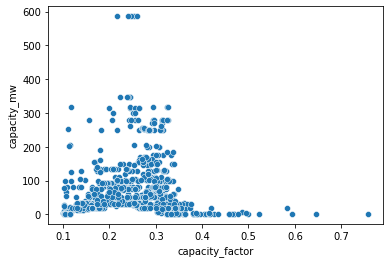

In [20]:
# df_all_concat.loc[mask,['generation_gwh', 'capacity_mw']]
sns.scatterplot(data=df_all_concat.loc[mask,['capacity_factor', 'capacity_mw']], x="capacity_factor", y="capacity_mw")

<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

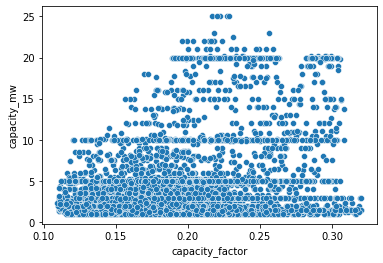

In [21]:
sns.scatterplot(data=df_all_concat.loc[:,['capacity_factor', 'capacity_mw']].drop(index_outliers, axis=0), x="capacity_factor", y="capacity_mw")


In [22]:
# df_all_concat[df_all_concat.loc[:,['name','generation_gwh', 'capacity_mw']].drop(index_outliers, axis=0)['name'].str.contains('CSP')]
# df_all_concat.loc[:,['name','generation_gwh', 'capacity_mw']].drop(index_outliers, axis=0)['name'].str.contains('CSP')
# df_all_concat.loc[~df_all_concat.drop(index_outliers, axis=0)['name'].str.contains('CSP')]
# data = df_all_concat.drop(index_outliers, axis=0).loc[df_all_concat.drop(index_outliers, axis=0)['name'].str.contains('CSP')]
# sns.scatterplot(data=data, x="generation_gwh", y="capacity_mw")
# df_all_concat.loc[:,['name','generation_gwh', 'capacity_mw']].drop(index_outliers, axis=0)['name']
# df_solar = df_solar[~df_solar['name'].str.contains('CSP')]

<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

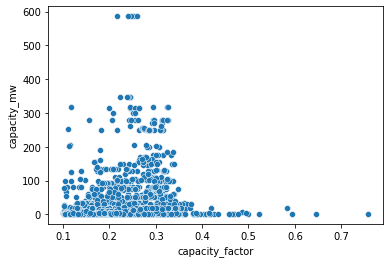

In [23]:
sns.scatterplot(data=df_all_concat.loc[:,['capacity_factor', 'capacity_mw']], x="capacity_factor", y="capacity_mw")


In [24]:
df_all_concat.drop(index_outliers, axis=0, inplace =True)

In [25]:
df_all_concat.drop(columns=['capacity_factor'], inplace = True)

In [26]:
df_all_concat.describe()

,ANN_ALLSKY_SFC_LW_DWN,ANN_ALLSKY_SFC_LW_UP,ANN_ALLSKY_SFC_SW_DIFF,ANN_ALLSKY_SFC_SW_DNI,ANN_ALLSKY_SFC_SW_DWN,ANN_ALLSKY_SFC_SW_UP,ANN_ALLSKY_SFC_SW_UP_MAX,ANN_CLRSKY_SFC_SW_DIFF,ANN_CLRSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DWN,...,winter_ALLSKY_SFC_SW_DWN,winter_ALLSKY_SFC_SW_UP,winter_ALLSKY_SFC_SW_UP_MAX,winter_CLRSKY_SFC_SW_DIFF,winter_CLRSKY_SFC_SW_DNI,winter_CLRSKY_SFC_SW_DWN,winter_CLRSKY_SFC_SW_UP,winter_T2M,capacity_mw,generation_gwh
count,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,...,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000
mean,323.838495,9.273566,1.538392,5.397146,4.628027,0.687848,1.542816,1.196445,8.107764,5.777991,...,5.884696,0.849045,1.136649,1.568136,8.353355,7.018832,1.004097,24.059409,4.323580,8.028295
std,19.556968,0.592402,0.192770,1.427591,0.729126,0.237568,0.551400,0.206738,0.865100,0.375904,...,0.775003,0.281315,0.297859,0.298962,1.025732,0.341018,0.261695,3.018289,4.444733,9.876832
min,256.220000,7.960000,1.100000,3.030000,3.400000,0.160000,0.320000,0.760000,6.800000,5.180000,...,4.620000,0.196667,0.270000,0.810000,6.603333,6.486667,0.246667,13.796667,1.000000,1.014000
25%,309.860000,8.820000,1.370000,4.280000,3.990000,0.530000,1.260000,0.950000,7.470000,5.410000,...,5.303333,0.683333,1.010000,1.231667,7.546667,6.740000,0.866667,21.900000,1.500000,2.471515
50%,321.740000,9.270000,1.600000,4.760000,4.480000,0.620000,1.450000,1.280000,7.690000,5.780000,...,5.563333,0.756667,1.076667,1.703333,7.846667,6.893333,0.956667,24.136667,2.900000,4.329000
75%,337.630000,9.700000,1.670000,6.940000,5.310000,0.860000,1.780000,1.370000,9.000000,6.095000,...,6.643333,1.083333,1.336667,1.803333,9.473333,7.396667,1.176667,25.863333,5.000000,9.114000
max,405.950000,11.080000,2.120000,8.250000,6.570000,1.560000,5.530000,1.610000,10.220000,7.560000,...,7.606667,1.856667,2.270000,2.170000,11.230000,8.023333,1.950000,34.663333,25.000000,53.326000


# STATSMODEL

In [ ]:
X = df_all_concat.drop(columns=['generation_gwh'])
# X = df_solar_2[['generation_gwh']]
y = df_all_concat['generation_gwh']

X = X.reindex(sorted(X.columns), axis=1)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.2,random_state = 0)

X_train_sm = sm.add_constant(X_train_sm)
model = sm.OLS(y_train_sm,X_train_sm)
results = model.fit()

print(f"ECM: {results.mse_resid}")

In [ ]:
# INDIVIDUAL SIGNIFICANCE
results.pvalues.sort_values()

In [ ]:
# OVERALL SIGNIFICANCE
results.f_pvalue

In [ ]:
results.rsquared

In [ ]:
results.rsquared_adj

In [ ]:
results.summary()

In [ ]:
# Aplicamos la funcion coef_summary a los results

coef_df = coef_summary(results)

In [ ]:
# Graficamos los p-valor
fig, ax = plt.subplots(figsize=(10,7))
coef_df = coef_df.sort_values(by='P>|t|', ascending = False)
ax = sns.barplot(x='variables', y='P>|t|', data=coef_df,
                 palette="Spectral")
ax.set_title('P-values', fontweight='bold', fontsize=20, y=1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('P-value', fontsize=10)
ax.set_xlabel('variables', fontsize=10)
plt.xticks(rotation=90, fontsize = 10 )
plt.yticks( fontsize = 10 )
plt.axhline(y = 0.05, color = 'black', linestyle = '--')
plt.show()

In [ ]:
# SCALED

X = df_all_concat.drop(columns=['generation_gwh'])
# X = df_solar_2[['generation_gwh']]
y = df_all_concat['generation_gwh']

min_max_scaler = MinMaxScaler()

power_transformer = PowerTransformer(method='yeo-johnson')
standard_scaler = StandardScaler()


x_scaled = min_max_scaler.fit_transform(X)
# x_scaled = power_transformer.fit_transform(X)
# x_scaled = standard_scaler.fit_transform(X)
df_X_scaled = pd.DataFrame(x_scaled, index=X.index, columns=X.columns)
df_all_concat_scaled = pd.concat([df_X_scaled,y], axis=1)
df_all_concat_scaled

In [ ]:
X = df_all_concat_scaled.drop(columns=['generation_gwh'])
# X = df_solar_2[['generation_gwh']]
y = df_all_concat_scaled['generation_gwh']

X = sm.add_constant(X)
model_scaled = sm.OLS(y,X)
results_scaled = model_scaled.fit()
# Error Cuadratico Medio de los Residuos
print(f"ECM: {results_scaled.mse_resid}")

In [ ]:
results_scaled.summary()

In [ ]:
coef_df_scaled = coef_summary(results_scaled)

In [ ]:
# Graficamos los p-valor
fig, ax = plt.subplots(figsize=(10,7))
coef_df_scaled = coef_df_scaled.sort_values(by='P>|t|', ascending = False)
ax = sns.barplot(x='variables', y='P>|t|', data=coef_df_scaled,
                 palette="Spectral")
ax.set_title('P-valor de los regresores', fontweight='bold', fontsize=20, y=1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('P-valor', fontsize=10)
ax.set_xlabel('variables', fontsize=10)
plt.xticks(rotation=90, fontsize = 10 )
plt.yticks( fontsize = 10 )
plt.axhline(y = 0.05, color = 'black', linestyle = '--')
plt.show()

In [ ]:
print(f"MSE Scaled: {results_scaled.rsquared}",'vs.',f"MSE: {results.rsquared}" )
print(f"Adj MSE Scaled: {results_scaled.rsquared_adj}",'vs.',f" Adj MSE: {results.rsquared_adj}" )
print(f"p-value Scaled: {results_scaled.f_pvalue}",'vs.',f" p-value: {results.f_pvalue}" )

# CORRELATION AND MUTUAL INFORMATION SCORES

## All Best K

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


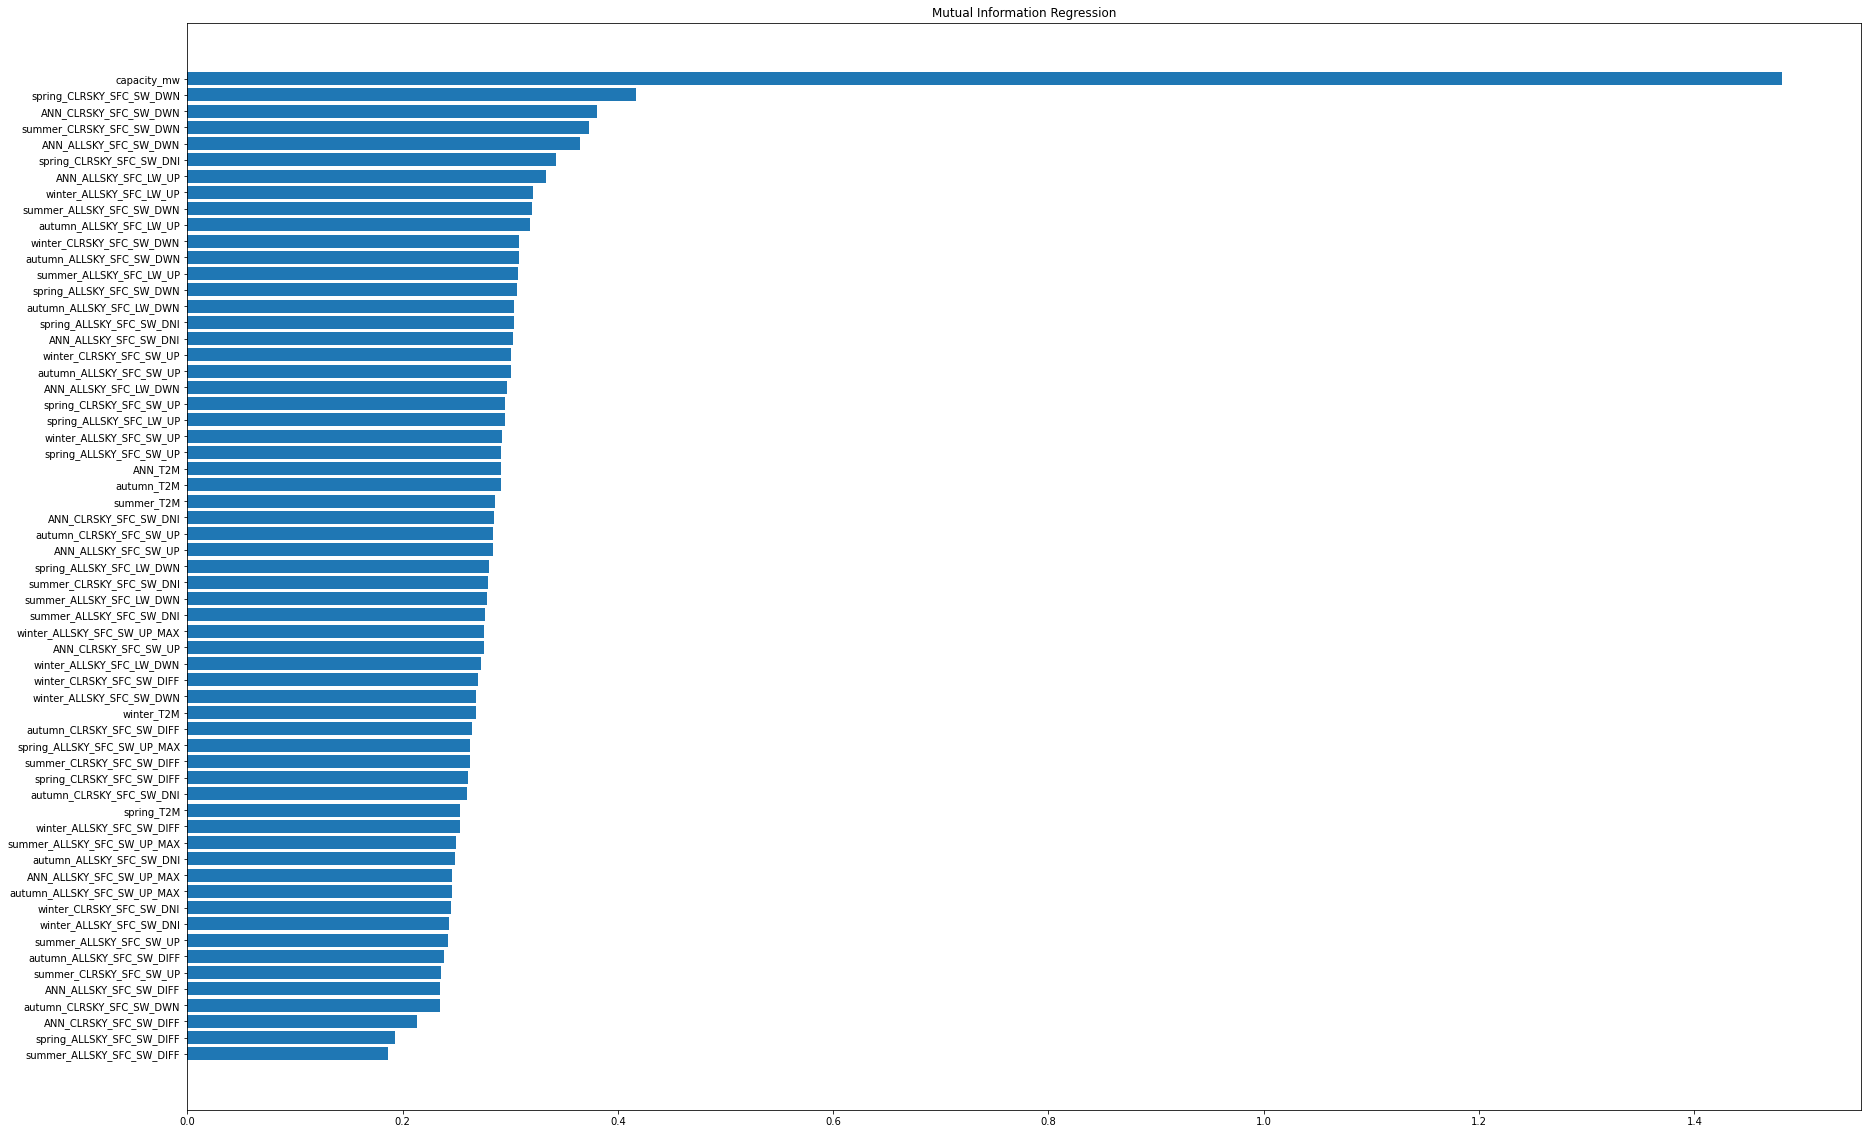

In [27]:
mi_scores = utils.make_mi_scores(df_all_concat.drop(columns=['generation_gwh']), df_all_concat[['generation_gwh']], "regression")

plt.figure(figsize=(30,20))
utils.plot_scores(mi_scores, "Mutual Information Regression")

In [28]:
X = df_all_concat.drop(columns=['generation_gwh'])
# X = df_all_concat[['generation_gwh']]
y = df_all_concat['generation_gwh']
# y
selector = SelectKBest(mutual_info_regression, k= 10)
new_X = selector.fit_transform(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]

# # df_new_X = pd.DataFrame(new_X, index=new_X.index, columns=new_X.columns)
df_all_concat_best_k_mi = pd.concat([features_df_new,y], axis=1)
# df_all_concat_best_k_mi
# selector.scores_
# utils.plot_scores(selector.scores_, "Best K")
# plt.plot(selector.scores_)
# plt.xticks(np.arange(df_all_concat.drop(columns=['generation_gwh']).columns.len), list(df_all_concat.drop(columns=['generation_gwh']).columns))

## All Linear Correlations (Pearson) > 0.30 Dataset

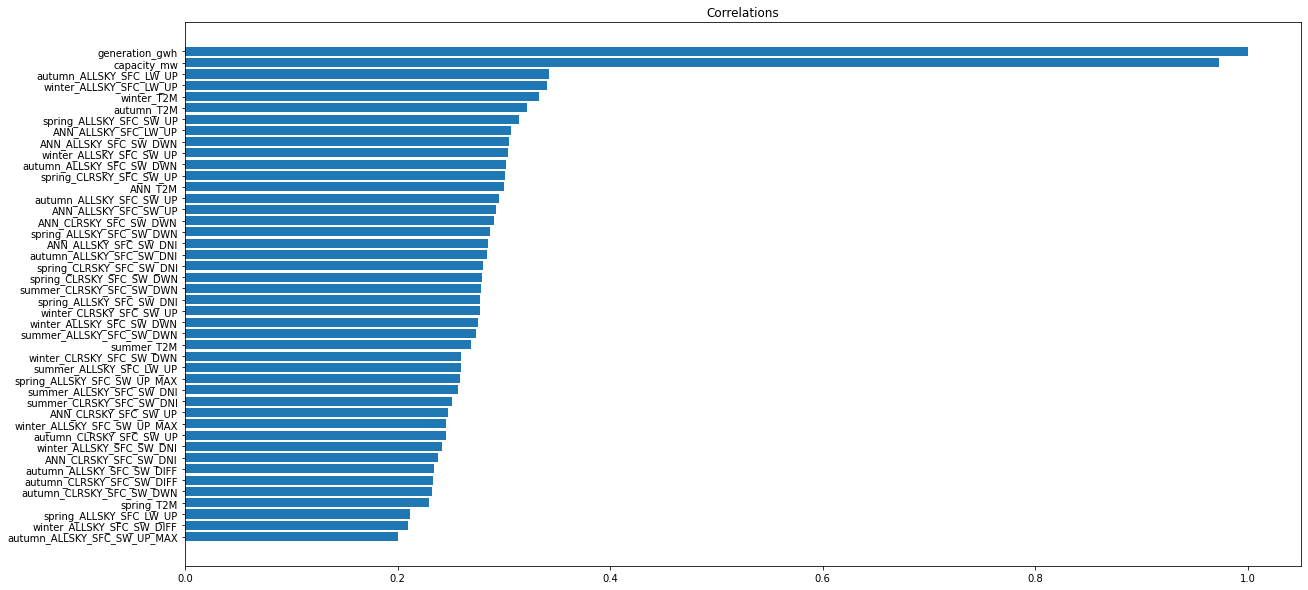

In [29]:
from matplotlib.pyplot import xlabel


# plt.bar(df_all_concat.corr().abs().unstack()['capacity_mw'].sort_values(ascending=False), height=df_all_concat.columns)
corr_matrix = df_all_concat.corr().abs()



target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# target_correlations[target_correlations > .20]
plt.figure(figsize=(20,10))
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [30]:
df_all_concat_lin_corr = df_all_concat[target_correlations[target_correlations > .20].index]
df_all_concat_lin_corr

,generation_gwh,capacity_mw,autumn_ALLSKY_SFC_LW_UP,winter_ALLSKY_SFC_LW_UP,winter_T2M,autumn_T2M,spring_ALLSKY_SFC_SW_UP,ANN_ALLSKY_SFC_LW_UP,ANN_ALLSKY_SFC_SW_DWN,winter_ALLSKY_SFC_SW_UP,...,autumn_CLRSKY_SFC_SW_UP,winter_ALLSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DNI,autumn_ALLSKY_SFC_SW_DIFF,autumn_CLRSKY_SFC_SW_DIFF,autumn_CLRSKY_SFC_SW_DWN,spring_T2M,spring_ALLSKY_SFC_LW_UP,winter_ALLSKY_SFC_SW_DIFF,autumn_ALLSKY_SFC_SW_UP_MAX
1,2.41461,1.9,9.386667,10.033333,21.703333,15.320000,0.313333,8.79,3.98,0.666667,...,0.946667,4.990000,7.24,2.160000,2.000000,7.506667,8.056667,8.176667,2.073333,1.133333
2,1.52800,1.3,9.540000,9.873333,23.150000,18.423333,0.290000,9.54,5.04,0.550000,...,0.780000,5.170000,8.75,2.460000,1.250000,8.076667,15.223333,9.570000,2.336667,0.800000
3,5.03600,3.8,9.386667,10.033333,21.666667,15.133333,0.313333,8.79,3.98,0.666667,...,0.946667,4.990000,7.24,2.160000,2.000000,7.506667,7.096667,8.176667,2.073333,1.133333
4,2.74100,1.9,9.386667,10.033333,21.666667,15.133333,0.313333,8.79,3.98,0.666667,...,0.946667,4.990000,7.24,2.160000,2.000000,7.506667,7.096667,8.176667,2.073333,1.133333
5,1.89400,1.0,10.290000,11.010000,23.150000,18.423333,0.630000,9.81,5.74,1.036667,...,1.273333,8.750000,9.30,1.486667,1.196667,8.250000,15.223333,9.136667,1.326667,1.663333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9655,3.55000,2.0,9.810000,10.350000,26.340000,20.823333,0.370000,9.24,4.40,0.713333,...,1.063333,4.590000,7.61,2.363333,1.880000,7.726667,10.650000,8.556667,2.286667,1.196667
9656,9.67800,5.0,10.173333,10.646667,26.403333,21.740000,0.363333,9.59,4.58,0.746667,...,1.056667,5.086667,7.60,2.383333,1.880000,7.650000,11.486667,8.970000,2.196667,1.210000
9657,9.02400,4.9,10.173333,10.646667,26.403333,21.740000,0.363333,9.59,4.58,0.746667,...,1.056667,5.086667,7.60,2.383333,1.880000,7.650000,11.486667,8.970000,2.196667,1.210000
9658,9.39600,5.0,10.173333,10.646667,26.403333,21.740000,0.363333,9.59,4.58,0.746667,...,1.056667,5.086667,7.60,2.383333,1.880000,7.650000,11.486667,8.970000,2.196667,1.210000


In [31]:
df_all_concat_lin_corr.columns

Index(['generation_gwh', 'capacity_mw', 'autumn_ALLSKY_SFC_LW_UP',
       'winter_ALLSKY_SFC_LW_UP', 'winter_T2M', 'autumn_T2M',
       'spring_ALLSKY_SFC_SW_UP', 'ANN_ALLSKY_SFC_LW_UP',
       'ANN_ALLSKY_SFC_SW_DWN', 'winter_ALLSKY_SFC_SW_UP',
       'autumn_ALLSKY_SFC_SW_DWN', 'spring_CLRSKY_SFC_SW_UP', 'ANN_T2M',
       'autumn_ALLSKY_SFC_SW_UP', 'ANN_ALLSKY_SFC_SW_UP',
       'ANN_CLRSKY_SFC_SW_DWN', 'spring_ALLSKY_SFC_SW_DWN',
       'ANN_ALLSKY_SFC_SW_DNI', 'autumn_ALLSKY_SFC_SW_DNI',
       'spring_CLRSKY_SFC_SW_DNI', 'spring_CLRSKY_SFC_SW_DWN',
       'summer_CLRSKY_SFC_SW_DWN', 'spring_ALLSKY_SFC_SW_DNI',
       'winter_CLRSKY_SFC_SW_UP', 'winter_ALLSKY_SFC_SW_DWN',
       'summer_ALLSKY_SFC_SW_DWN', 'summer_T2M', 'winter_CLRSKY_SFC_SW_DWN',
       'summer_ALLSKY_SFC_LW_UP', 'spring_ALLSKY_SFC_SW_UP_MAX',
       'summer_ALLSKY_SFC_SW_DNI', 'summer_CLRSKY_SFC_SW_DNI',
       'ANN_CLRSKY_SFC_SW_UP', 'winter_ALLSKY_SFC_SW_UP_MAX',
       'autumn_CLRSKY_SFC_SW_UP', 'winter_ALLSKY

## Annual Dataset

In [32]:
corr_matrix

,ANN_ALLSKY_SFC_LW_DWN,ANN_ALLSKY_SFC_LW_UP,ANN_ALLSKY_SFC_SW_DIFF,ANN_ALLSKY_SFC_SW_DNI,ANN_ALLSKY_SFC_SW_DWN,ANN_ALLSKY_SFC_SW_UP,ANN_ALLSKY_SFC_SW_UP_MAX,ANN_CLRSKY_SFC_SW_DIFF,ANN_CLRSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DWN,...,winter_ALLSKY_SFC_SW_DWN,winter_ALLSKY_SFC_SW_UP,winter_ALLSKY_SFC_SW_UP_MAX,winter_CLRSKY_SFC_SW_DIFF,winter_CLRSKY_SFC_SW_DNI,winter_CLRSKY_SFC_SW_DWN,winter_CLRSKY_SFC_SW_UP,winter_T2M,capacity_mw,generation_gwh
ANN_ALLSKY_SFC_LW_DWN,1.000000,0.474839,0.472773,0.194914,0.001080,0.329747,0.498984,0.459933,0.394206,0.099262,...,0.175844,0.322177,0.407710,0.362964,0.455169,0.172830,0.363150,0.521528,0.120510,0.089162
ANN_ALLSKY_SFC_LW_UP,0.474839,1.000000,0.405827,0.736909,0.841900,0.516016,0.178724,0.429803,0.518793,0.827866,...,0.688272,0.523293,0.351596,0.496926,0.427331,0.684357,0.400220,0.833820,0.252177,0.306939
ANN_ALLSKY_SFC_SW_DIFF,0.472773,0.405827,1.000000,0.824762,0.671450,0.681298,0.239985,0.786485,0.722459,0.457827,...,0.808778,0.772221,0.684680,0.772295,0.780731,0.660284,0.667253,0.274627,0.105561,0.184518
ANN_ALLSKY_SFC_SW_DNI,0.194914,0.736909,0.824762,1.000000,0.968661,0.826656,0.175947,0.865498,0.906082,0.861404,...,0.949811,0.852628,0.708949,0.870998,0.864989,0.932283,0.738600,0.533963,0.194400,0.284877
ANN_ALLSKY_SFC_SW_DWN,0.001080,0.841900,0.671450,0.968661,1.000000,0.781020,0.087613,0.786065,0.864448,0.947772,...,0.918427,0.786712,0.624716,0.810477,0.790536,0.942776,0.670900,0.623819,0.219820,0.304826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
winter_CLRSKY_SFC_SW_DWN,0.172830,0.684357,0.660284,0.932283,0.942776,0.760750,0.131392,0.872310,0.938107,0.919063,...,0.918221,0.786516,0.637731,0.896175,0.903418,1.000000,0.688193,0.435788,0.171932,0.259911
winter_CLRSKY_SFC_SW_UP,0.363150,0.400220,0.667253,0.738600,0.670900,0.952172,0.555865,0.675875,0.744386,0.602384,...,0.677361,0.970979,0.981709,0.605805,0.661601,0.688193,1.000000,0.365858,0.205943,0.277300
winter_T2M,0.521528,0.833820,0.274627,0.533963,0.623819,0.434061,0.126608,0.211099,0.299216,0.601544,...,0.481031,0.442807,0.324900,0.243046,0.182126,0.435788,0.365858,1.000000,0.299127,0.333045
capacity_mw,0.120510,0.252177,0.105561,0.194400,0.219820,0.216224,0.032921,0.108468,0.147491,0.217848,...,0.186087,0.222412,0.179642,0.100811,0.098477,0.171932,0.205943,0.299127,1.000000,0.973163


In [33]:
# df_solar_2 = df_solar_2[(df_solar_2['capacity_mw'] < 100)].copy()

columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('ANN') | df_all_concat.columns.str.contains('capacity_mw')
df_all_concat_annual = df_all_concat.loc[:,columns_keep]

corr_matrix = df_all_concat_annual.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
# df_all_concat_annual.drop(columns=to_drop, inplace=True)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


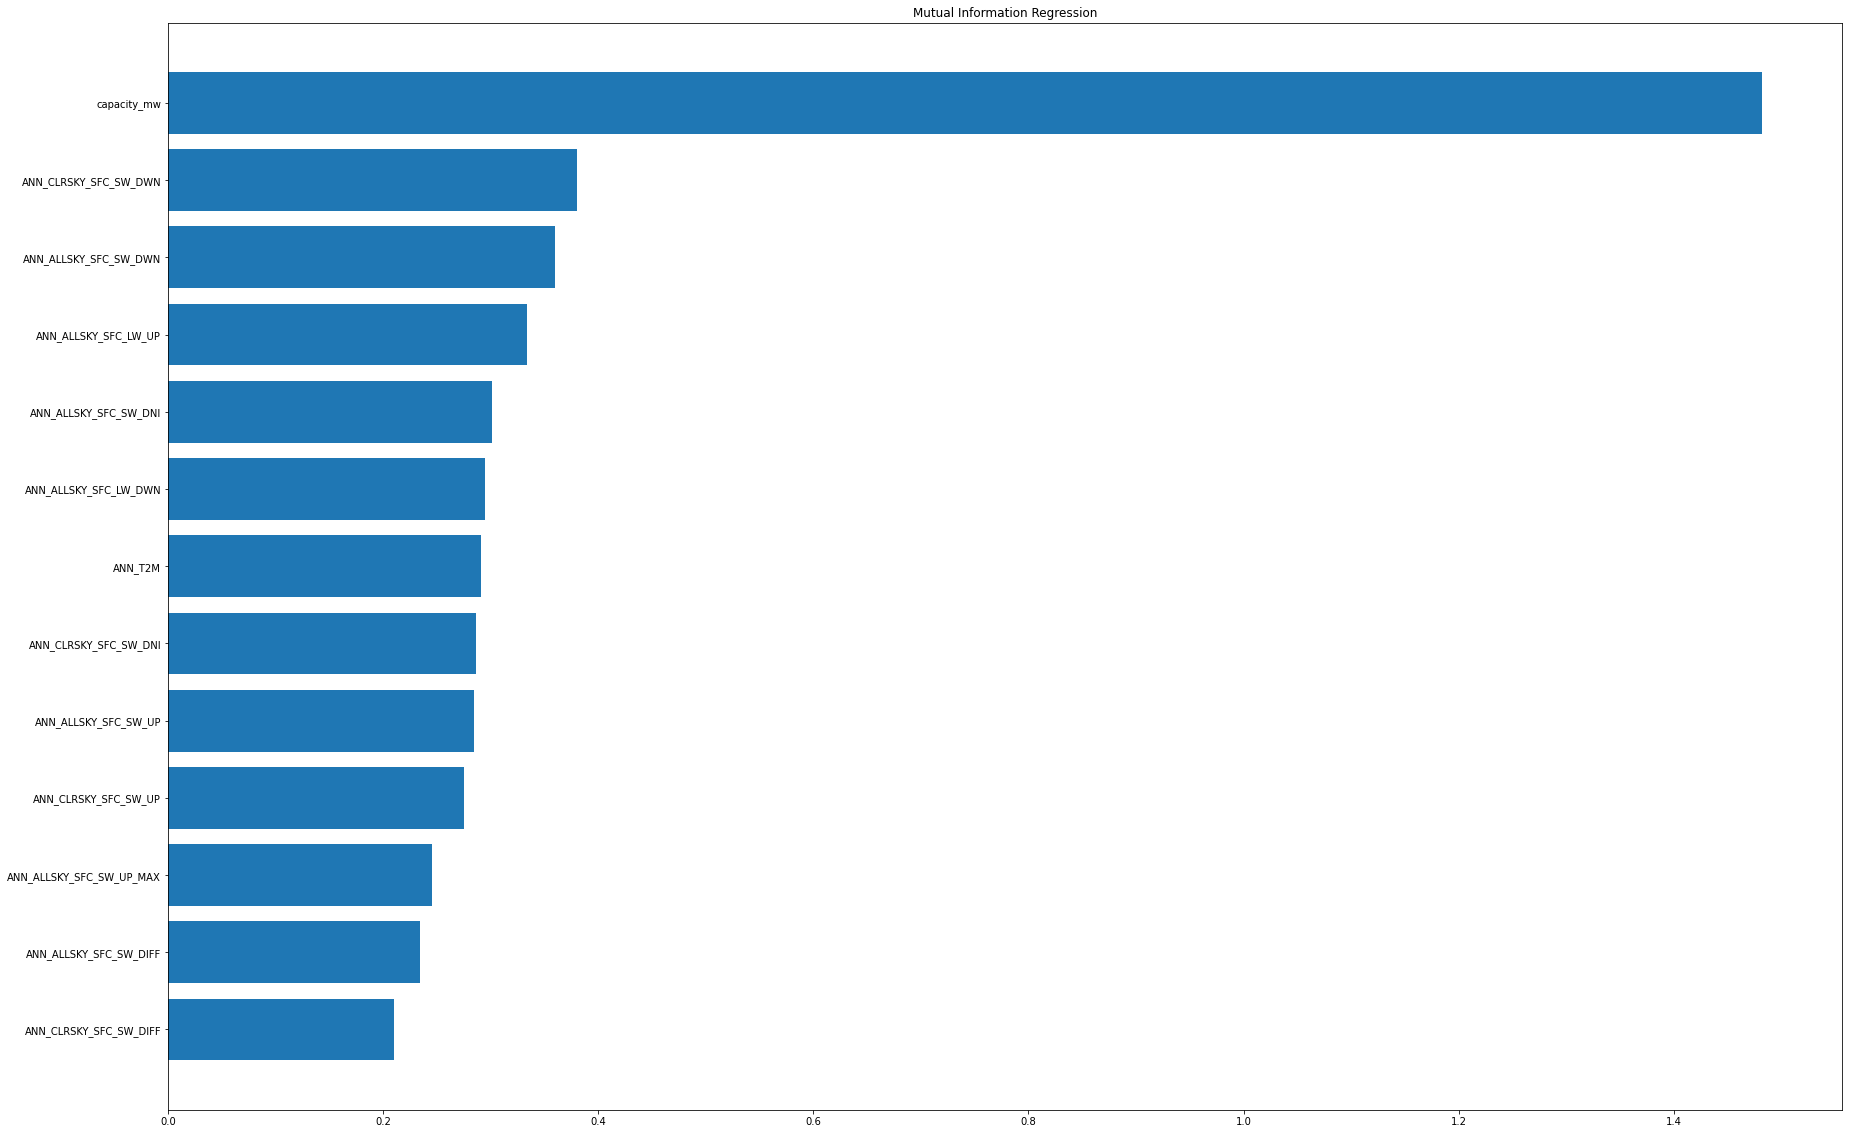

In [34]:
mi_scores = utils.make_mi_scores(df_all_concat_annual.drop(columns=['generation_gwh']), df_all_concat_annual[['generation_gwh']], "regression")

plt.figure(figsize=(30,20))
utils.plot_scores(mi_scores, "Mutual Information Regression")

## Annual Best K (Mutual Information) Dataset 

In [35]:
X = df_all_concat_annual.drop(columns=['generation_gwh'])
# X = df_all_concat_annual[['generation_gwh']]
y = df_all_concat_annual['generation_gwh']
# y
selector = SelectKBest(mutual_info_regression, k= 10)
new_X = selector.fit_transform(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]

# # df_new_X = pd.DataFrame(new_X, index=new_X.index, columns=new_X.columns)
df_all_concat_annual_best_k_mi = pd.concat([features_df_new,y], axis=1)
# df_all_concat_annual_best_k_mi
# selector.scores_
# utils.plot_scores(selector.scores_, "Best K")
# plt.plot(selector.scores_)
# plt.xticks(np.arange(df_all_concat_annual.drop(columns=['generation_gwh']).columns.len), list(df_all_concat_annual.drop(columns=['generation_gwh']).columns))

In [36]:
df_all_concat_annual_best_k_mi

,ANN_ALLSKY_SFC_LW_DWN,ANN_ALLSKY_SFC_LW_UP,ANN_ALLSKY_SFC_SW_DNI,ANN_ALLSKY_SFC_SW_DWN,ANN_ALLSKY_SFC_SW_UP,ANN_CLRSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DWN,ANN_CLRSKY_SFC_SW_UP,ANN_T2M,capacity_mw,generation_gwh
1,317.53,8.79,4.28,3.98,0.52,7.24,5.40,0.72,11.73,1.9,2.41461
2,341.24,9.54,5.35,5.04,0.46,8.75,6.18,0.55,17.25,1.3,1.52800
3,317.53,8.79,4.28,3.98,0.52,7.24,5.40,0.72,11.19,3.8,5.03600
4,317.53,8.79,4.28,3.98,0.52,7.24,5.40,0.72,11.19,1.9,2.74100
5,301.52,9.81,7.79,5.74,0.87,9.30,6.28,0.97,17.25,1.0,1.89400
...,...,...,...,...,...,...,...,...,...,...,...
9655,334.89,9.24,4.53,4.40,0.58,7.61,5.84,0.78,16.36,2.0,3.55000
9656,350.29,9.59,4.81,4.58,0.62,7.60,5.84,0.79,16.85,5.0,9.67800
9657,350.29,9.59,4.81,4.58,0.62,7.60,5.84,0.79,16.85,4.9,9.02400
9658,350.29,9.59,4.81,4.58,0.62,7.60,5.84,0.79,16.85,5.0,9.39600


## Annual Linear Correlations (Pearson) > 0.30 Dataset

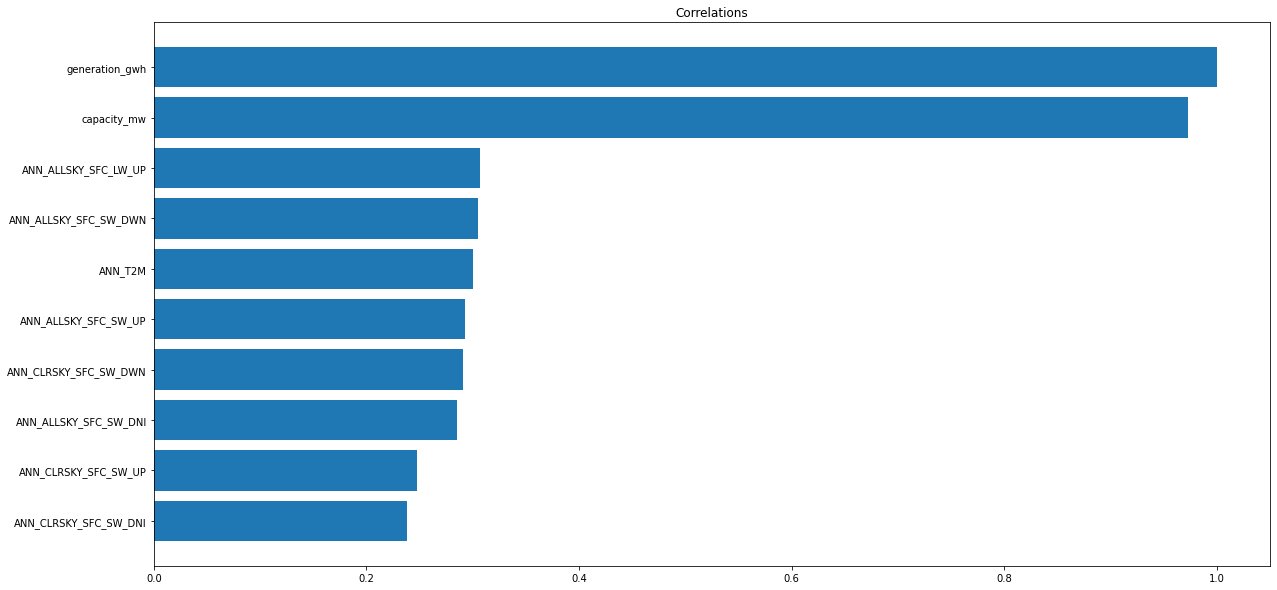

In [37]:
from matplotlib.pyplot import xlabel


# plt.bar(df_all_concat_annual.corr().abs().unstack()['capacity_mw'].sort_values(ascending=False), height=df_all_concat_annual.columns)
corr_matrix = df_all_concat_annual.corr().abs()



target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# target_correlations[target_correlations > .30]
plt.figure(figsize=(20,10))
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [38]:
df_all_concat_annual_lin_corr = df_all_concat_annual[target_correlations[target_correlations > .20].index]
df_all_concat_annual_lin_corr

,generation_gwh,capacity_mw,ANN_ALLSKY_SFC_LW_UP,ANN_ALLSKY_SFC_SW_DWN,ANN_T2M,ANN_ALLSKY_SFC_SW_UP,ANN_CLRSKY_SFC_SW_DWN,ANN_ALLSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_UP,ANN_CLRSKY_SFC_SW_DNI
1,2.41461,1.9,8.79,3.98,11.73,0.52,5.40,4.28,0.72,7.24
2,1.52800,1.3,9.54,5.04,17.25,0.46,6.18,5.35,0.55,8.75
3,5.03600,3.8,8.79,3.98,11.19,0.52,5.40,4.28,0.72,7.24
4,2.74100,1.9,8.79,3.98,11.19,0.52,5.40,4.28,0.72,7.24
5,1.89400,1.0,9.81,5.74,17.25,0.87,6.28,7.79,0.97,9.30
...,...,...,...,...,...,...,...,...,...,...
9655,3.55000,2.0,9.24,4.40,16.36,0.58,5.84,4.53,0.78,7.61
9656,9.67800,5.0,9.59,4.58,16.85,0.62,5.84,4.81,0.79,7.60
9657,9.02400,4.9,9.59,4.58,16.85,0.62,5.84,4.81,0.79,7.60
9658,9.39600,5.0,9.59,4.58,16.85,0.62,5.84,4.81,0.79,7.60


In [39]:
# g = sns.PairGrid(df_all_concat_annual_lin_corr)
# g.map(sns.scatterplot)

# sns.pairplot(df_all_concat_annual_lin_corr)

## Capacity and Shortwave Down features

In [40]:
columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('SW_DWN') | df_all_concat.columns.str.contains('capacity_mw') | df_all_concat.columns.str.contains('capacity_factor')
df_all_concat_capacity_shortwave_down = df_all_concat.loc[:,columns_keep]
df_all_concat_capacity_shortwave_down
# sns.pairplot(df_all_concat_capacity_shortwave_down)

,ANN_ALLSKY_SFC_SW_DWN,ANN_CLRSKY_SFC_SW_DWN,autumn_ALLSKY_SFC_SW_DWN,autumn_CLRSKY_SFC_SW_DWN,spring_ALLSKY_SFC_SW_DWN,spring_CLRSKY_SFC_SW_DWN,summer_ALLSKY_SFC_SW_DWN,summer_CLRSKY_SFC_SW_DWN,winter_ALLSKY_SFC_SW_DWN,winter_CLRSKY_SFC_SW_DWN,capacity_mw,generation_gwh
1,3.98,5.40,5.663333,7.506667,2.336667,3.253333,2.720000,4.113333,5.183333,6.693333,1.9,2.41461
2,5.04,6.18,6.420000,8.076667,3.710000,4.240000,4.206667,5.016667,5.813333,7.366667,1.3,1.52800
3,3.98,5.40,5.663333,7.506667,2.336667,3.253333,2.720000,4.113333,5.183333,6.693333,3.8,5.03600
4,3.98,5.40,5.663333,7.506667,2.336667,3.253333,2.720000,4.113333,5.183333,6.693333,1.9,2.74100
5,5.74,6.28,7.536667,8.250000,3.903333,4.283333,4.503333,5.073333,7.010000,7.490000,1.0,1.89400
...,...,...,...,...,...,...,...,...,...,...,...,...
9655,4.40,5.84,5.986667,7.726667,2.830000,3.953333,3.363333,4.696667,5.393333,6.946667,2.0,3.55000
9656,4.58,5.84,6.160000,7.650000,2.963333,4.003333,3.546667,4.770000,5.630000,6.906667,5.0,9.67800
9657,4.58,5.84,6.160000,7.650000,2.963333,4.003333,3.546667,4.770000,5.630000,6.906667,4.9,9.02400
9658,4.58,5.84,6.160000,7.650000,2.963333,4.003333,3.546667,4.770000,5.630000,6.906667,5.0,9.39600


In [41]:
# sns.pairplot(df_all_concat_capacity_shortwave_down)

## Only Capacity

In [42]:
columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('capacity_mw')
df_all_concat_only_capacity = df_all_concat.loc[:,columns_keep]
df_all_concat_only_capacity

,capacity_mw,generation_gwh
1,1.9,2.41461
2,1.3,1.52800
3,3.8,5.03600
4,1.9,2.74100
5,1.0,1.89400
...,...,...
9655,2.0,3.55000
9656,5.0,9.67800
9657,4.9,9.02400
9658,5.0,9.39600


## Only Capacity and Capacity Factor

In [43]:
columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('capacity_mw') | df_all_concat.columns.str.contains('capacity_factor')
df_all_concat_only_capacity_and_factor = df_all_concat.loc[:,columns_keep]
df_all_concat_only_capacity_and_factor

,capacity_mw,generation_gwh
1,1.9,2.41461
2,1.3,1.52800
3,3.8,5.03600
4,1.9,2.74100
5,1.0,1.89400
...,...,...
9655,2.0,3.55000
9656,5.0,9.67800
9657,4.9,9.02400
9658,5.0,9.39600


In [ ]:
pd.qcut(df_all_concat['capacity_mw'], 4)

In [ ]:
category = pd.qcut(df_all_concat['capacity_mw'], 4).cat.codes.rename('category')
# category = pd.cut(df_all_concat['capacity_mw'], 6).cat.codes.rename('category')
df_all_concat_w_category = pd.concat([df_all_concat, category], axis=1)

In [ ]:
category.value_counts()

In [ ]:
sns.pairplot(df_all_concat_w_category, hue='category')

# X AND Y

In [44]:
dataframes_dict_X_y = {
    'df_all_concat_annual_lin_corr' : {},
    'df_all_concat_annual_best_k_mi': {},
    'df_all_concat_lin_corr': {},
    'df_all_concat_best_k_mi': {},
    'df_all_concat': {},
    'df_all_concat_capacity_shortwave_down': {},
    'df_all_concat_only_capacity': {},
    'df_all_concat_only_capacity_and_factor': {}
}


In [45]:
iso_df_all_concat_annual_lin_corr = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_annual_lin_corr.fit_predict(df_all_concat_annual_lin_corr)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_annual_lin_corr[mask].index
df_all_concat_annual_lin_corr.drop(index_outliers, axis=0, inplace =True)

X = df_all_concat_annual_lin_corr.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_annual_lin_corr[['capacity_mw']]
y = df_all_concat_annual_lin_corr['generation_gwh']



dataframes_dict_X_y['df_all_concat_annual_lin_corr']['X'] = X
dataframes_dict_X_y['df_all_concat_annual_lin_corr']['y'] = y

/tmp/ipykernel_3310/2987193366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat_annual_lin_corr.drop(index_outliers, axis=0, inplace =True)


In [46]:
iso_df_all_concat_lin_corr = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_lin_corr.fit_predict(df_all_concat_lin_corr)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_lin_corr[mask].index
df_all_concat_lin_corr.drop(index_outliers, axis=0, inplace =True)


X = df_all_concat_lin_corr.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_lin_corr[['capacity_mw']]
y = df_all_concat_lin_corr['generation_gwh']

dataframes_dict_X_y['df_all_concat_lin_corr']['X'] = X
dataframes_dict_X_y['df_all_concat_lin_corr']['y'] = y

/tmp/ipykernel_3310/2728832043.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat_lin_corr.drop(index_outliers, axis=0, inplace =True)


In [47]:
# X = df_all_concat_w_category.drop(columns=['generation_gwh'])
# # X = df_solar_2[['capacity_mw']]
# y = df_all_concat_w_category['generation_gwh']

In [48]:
iso_df_all_concat_annual_best_k_mi = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_annual_best_k_mi.fit_predict(df_all_concat_annual_best_k_mi)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_annual_best_k_mi[mask].index
df_all_concat_annual_best_k_mi.drop(index_outliers, axis=0, inplace =True)


X = df_all_concat_annual_best_k_mi.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_solar_2[['capacity_mw']]
y = df_all_concat_annual_best_k_mi['generation_gwh']


dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['X'] = X
dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['y'] = y

In [49]:
iso_df_all_concat_best_k_mi = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_best_k_mi.fit_predict(df_all_concat_best_k_mi)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_best_k_mi[mask].index
df_all_concat_best_k_mi.drop(index_outliers, axis=0, inplace =True)


X = df_all_concat_best_k_mi.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_solar_2[['capacity_mw']]
y = df_all_concat_best_k_mi['generation_gwh']


dataframes_dict_X_y['df_all_concat_best_k_mi']['X'] = X
dataframes_dict_X_y['df_all_concat_best_k_mi']['y'] = y

In [50]:
iso_df_all_concat = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat.fit_predict(df_all_concat)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat[mask].index
df_all_concat.drop(index_outliers, axis=0, inplace =True)

X = df_all_concat.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat[['capacity_mw']]
y = df_all_concat['generation_gwh']


dataframes_dict_X_y['df_all_concat']['X'] = X
dataframes_dict_X_y['df_all_concat']['y'] = y

In [51]:
X = df_all_concat_only_capacity[['capacity_mw']]
X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_only_capacity[['capacity_mw']]
y = df_all_concat_only_capacity['generation_gwh']

dataframes_dict_X_y['df_all_concat_only_capacity']['X'] = X
dataframes_dict_X_y['df_all_concat_only_capacity']['y'] = y

In [52]:
X = df_all_concat_only_capacity_and_factor[['capacity_mw']]
X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_only_capacity_and_factor[['capacity_mw']]
y = df_all_concat_only_capacity_and_factor['generation_gwh']

dataframes_dict_X_y['df_all_concat_only_capacity_and_factor']['X'] = X
dataframes_dict_X_y['df_all_concat_only_capacity_and_factor']['y'] = y

In [53]:
iso_df_all_concat_capacity_shortwave_down = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_capacity_shortwave_down.fit_predict(df_all_concat_capacity_shortwave_down)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_capacity_shortwave_down[mask].index
df_all_concat_capacity_shortwave_down.drop(index_outliers, axis=0, inplace =True)

X = df_all_concat_capacity_shortwave_down.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
# X = df_all_concat_capacity_shortwave_down[['capacity_mw']]
y = df_all_concat_capacity_shortwave_down['generation_gwh']


dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X'] = X
dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y'] = y

/tmp/ipykernel_3310/2596333196.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat_capacity_shortwave_down.drop(index_outliers, axis=0, inplace =True)


In [54]:
# X = df_all_concat_scaled.drop(columns=['generation_gwh'])
# # X = df_all_concat_scaled[['capacity_mw']]
# y = df_all_concat_scaled['generation_gwh']

In [55]:
# del dataframes_dict_X_y['df_all_concat_only_capacity']
# dataframes_dict_X_y['df_all_concat_capacity_shortwave_down'] = {}
# dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X'] = X
# dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y'] = y

In [56]:
for i, df_X_y in dataframes_dict_X_y.items():
    list_train_test_split = train_test_split(df_X_y['X'], df_X_y['y'], test_size=0.2,random_state = 0)
    dataframes_dict_X_y[i]['X_train'] = list_train_test_split[0]
    dataframes_dict_X_y[i]['X_test'] = list_train_test_split[1]
    dataframes_dict_X_y[i]['y_train'] = list_train_test_split[2]
    dataframes_dict_X_y[i]['y_test'] = list_train_test_split[3]

In [57]:
# X_all = X_all.reindex(sorted(X.columns), axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2,random_state = 0)

# DECISION TREE REGRESSOR

df_all_concat_annual_lin_corr best_tree_size: 80
df_all_concat_annual_best_k_mi best_tree_size: 80
df_all_concat_lin_corr best_tree_size: 50
df_all_concat_best_k_mi best_tree_size: 100
df_all_concat best_tree_size: 100
df_all_concat_capacity_shortwave_down best_tree_size: 50
df_all_concat_only_capacity best_tree_size: 500
df_all_concat_only_capacity_and_factor best_tree_size: 500


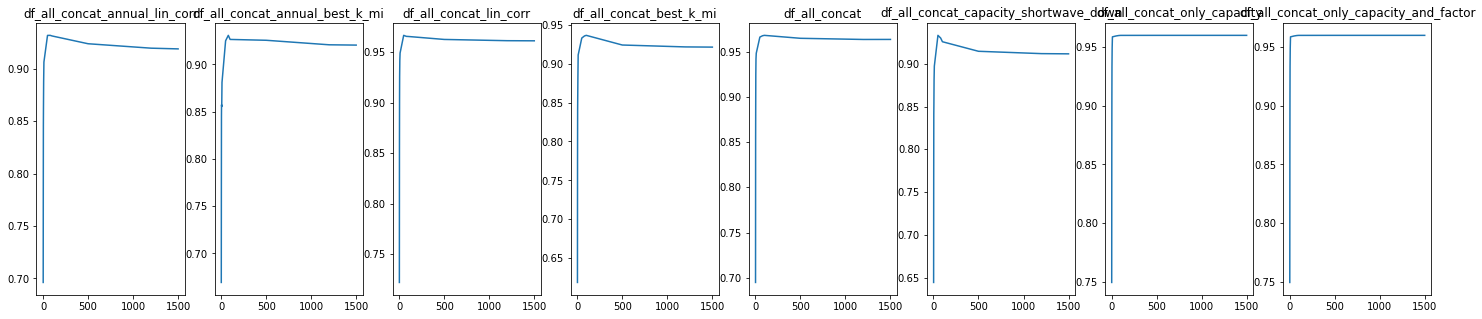

In [58]:
candidate_max_leaf_nodes = [2, 3, 4, 5, 7, 10, 50, 80, 100, 500, 1200, 1500]
# candidate_max_leaf_nodes = [2, 3, 4, 5, 7, 10]

# plt.figure(figsize=(25,15))
fig, ax =plt.subplots(1,len(dataframes_dict_X_y), figsize=(25,5))
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = {}
    results = {node: utils.get_accuracy_tree("regression",node, df_X_y['X_train'], df_X_y['X_test'], df_X_y['y_train'], df_X_y['y_test']) for node in candidate_max_leaf_nodes}
    best_tree_size = max(results, key=results.get)
    print(f'{k} best_tree_size: {best_tree_size}')
    dataframes_dict_X_y[k]['best_tree_size'] = best_tree_size
    ax[i].set_title(k)
    sns.lineplot(data=results, x= results.keys(), y= results.values(), ax=ax[i])

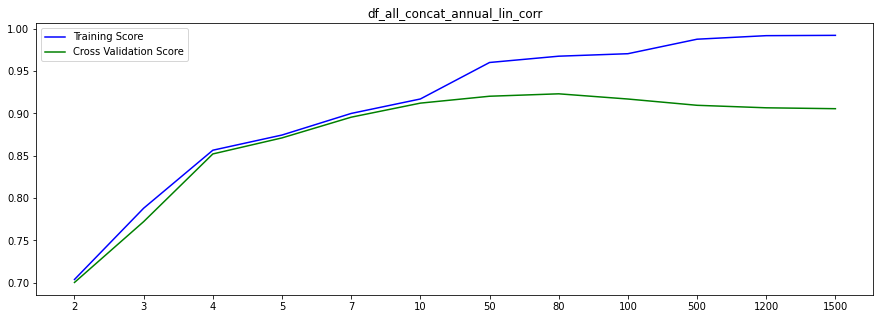

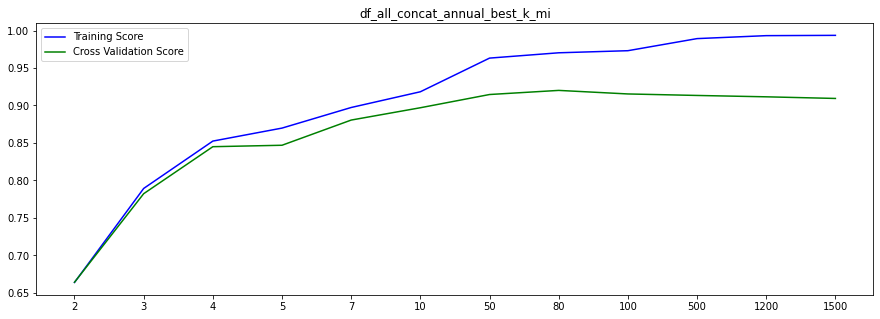

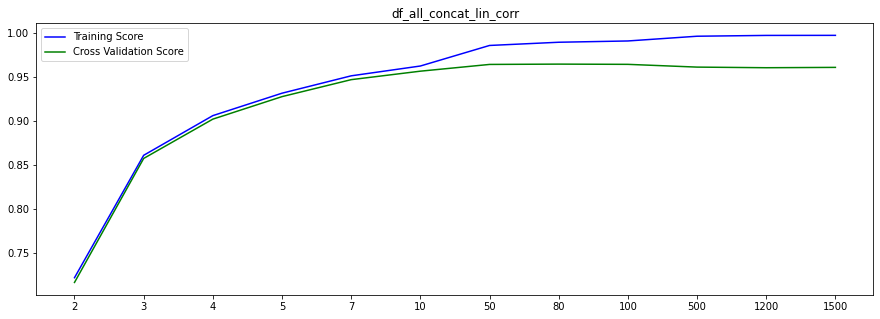

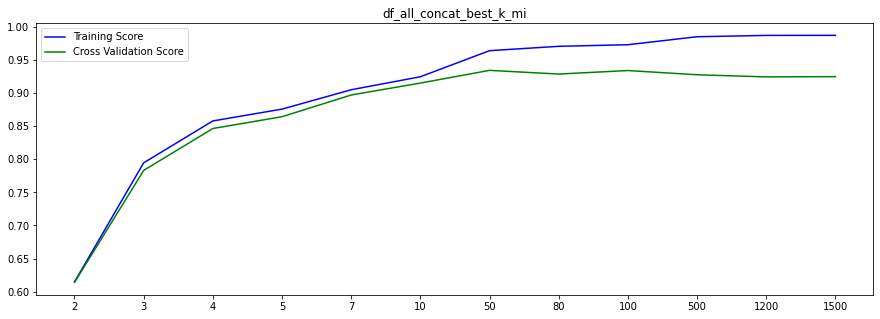

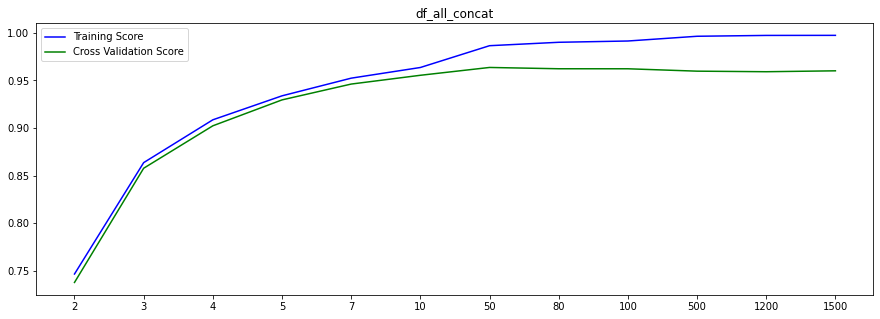

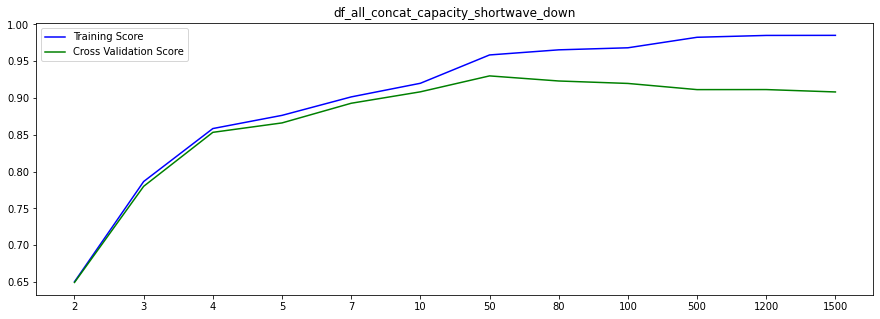

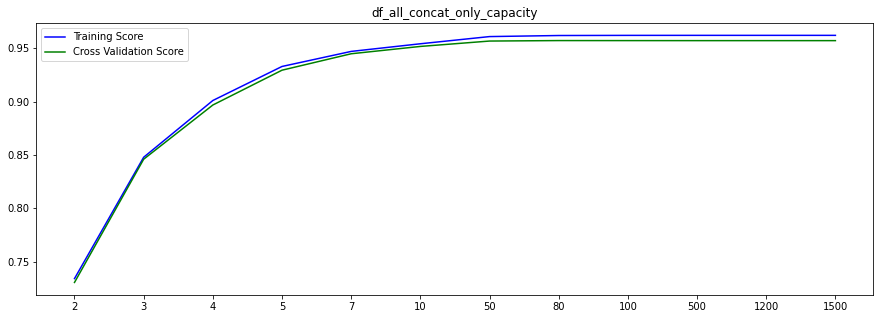

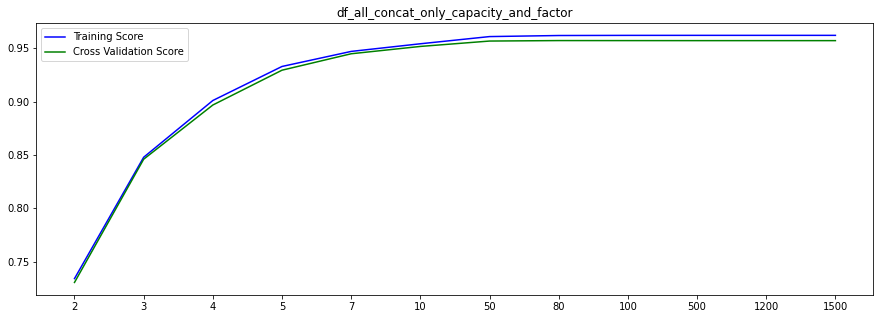

In [59]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    validation_curve_plot(k, DecisionTreeRegressor(), df_X_y['X_train'], df_X_y['y_train'], 'max_leaf_nodes', np.array(candidate_max_leaf_nodes))

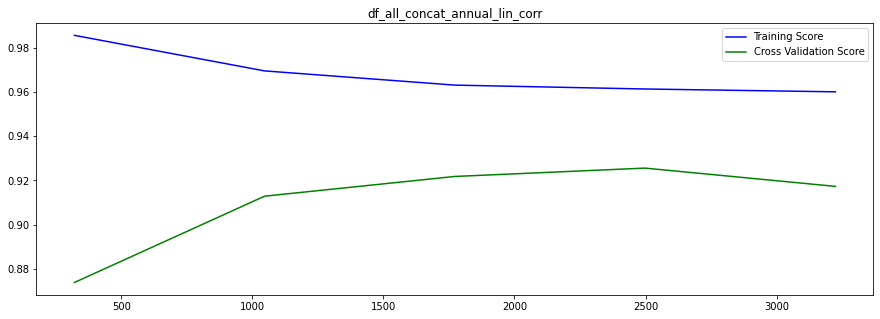

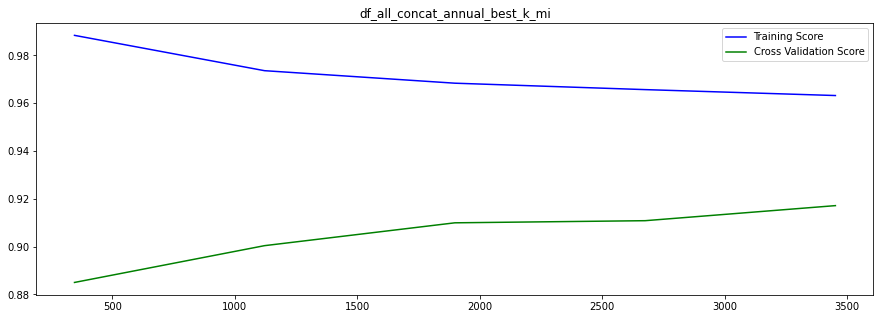

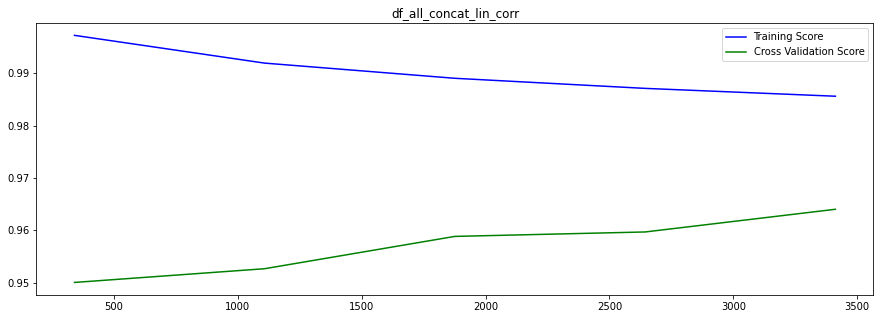

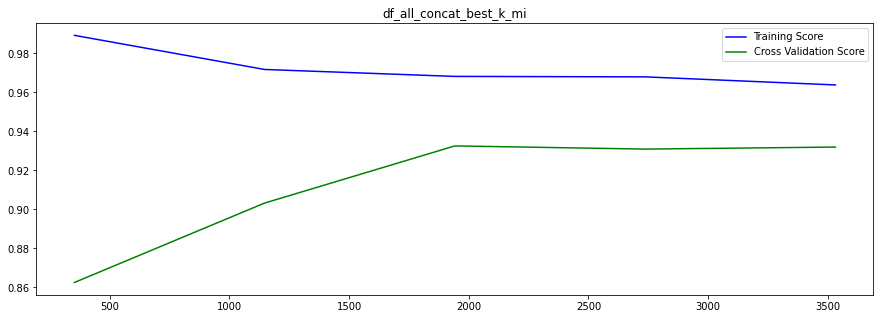

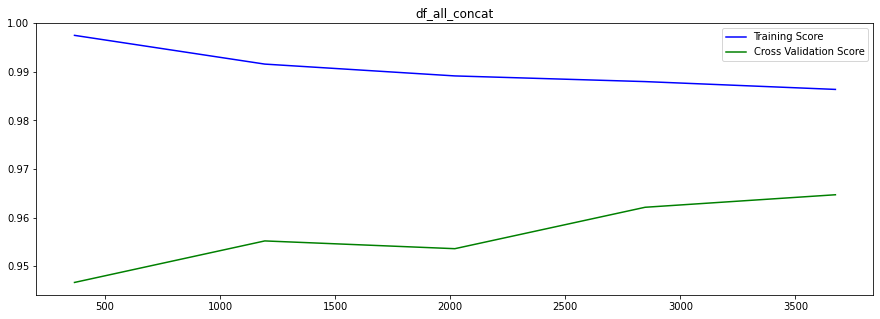

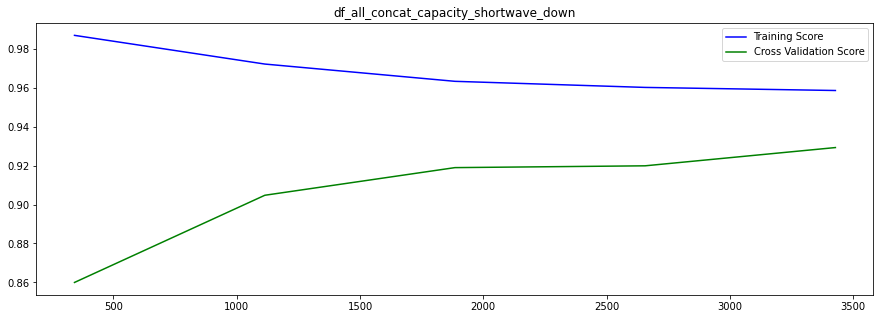

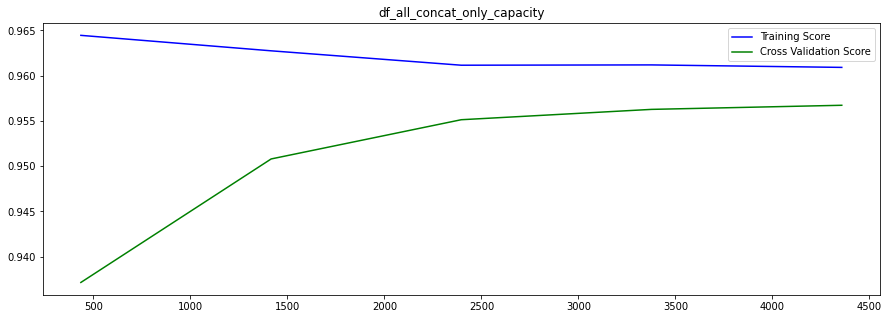

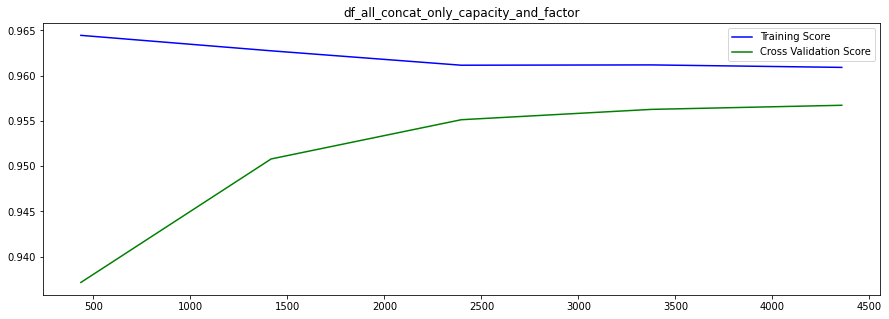

In [60]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    learning_curve_plot(k, DecisionTreeRegressor(max_leaf_nodes=50),df_X_y['X_train'], df_X_y['y_train'])

In [61]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], DecisionTreeRegressor(max_leaf_nodes=50), k)
    print(k)
    print(results)

df_all_concat_annual_lin_corr
{'test_r2': 0.9191133195534558, 'test_mean_squared_error': 1.0552916061541382, 'test_mean_absolute_error': 0.600708016596395, 'test_root_mean_squared_error': 1.0191903604294017}
df_all_concat_annual_best_k_mi
{'test_r2': 0.9134371946305186, 'test_mean_squared_error': 1.298720250595953, 'test_mean_absolute_error': 0.6329639438772692, 'test_root_mean_squared_error': 1.13901592786886}
df_all_concat_lin_corr
{'test_r2': 0.964120390800821, 'test_mean_squared_error': 2.5540633307478164, 'test_mean_absolute_error': 0.8419930403578771, 'test_root_mean_squared_error': 1.5934408677677616}
df_all_concat_best_k_mi
{'test_r2': 0.9295131805487873, 'test_mean_squared_error': 1.209219645840922, 'test_mean_absolute_error': 0.6346981504815792, 'test_root_mean_squared_error': 1.0966610345407142}
df_all_concat
{'test_r2': 0.9632003543418612, 'test_mean_squared_error': 3.1615950234462504, 'test_mean_absolute_error': 0.8945478845867079, 'test_root_mean_squared_error': 1.7733408

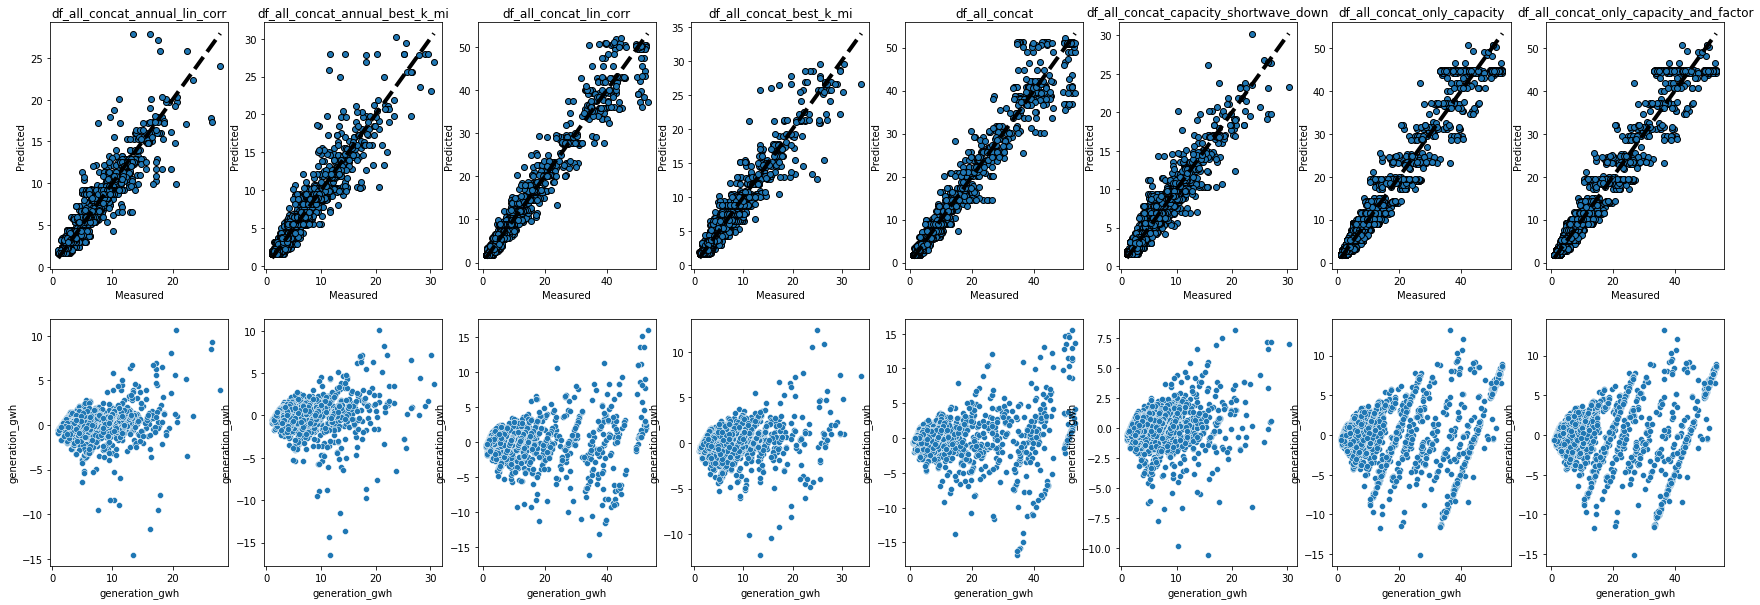

In [62]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(DecisionTreeRegressor(max_leaf_nodes=50), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
# Define model. Specify a number for random_state to ensure same results each run
tree_model = DecisionTreeRegressor(max_leaf_nodes = 50)

# Fit model
tree_model.fit(dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['X_train'], dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['y_train'])
y_pred = tree_model.predict(dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['X_test'])

# RANDOM FOREST REGRESSOR

In [63]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [int(x) for x in np.arange(10, 501, 10)]
# Minimum numbers of samples required to split a node
min_samples_split = [int(x) for x in np.arange(10, 51, 10)]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(5, 101, 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_leaf_nodes = [int(x) for x in np.arange(10, 501, 10)]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes
            }



In [64]:

# rf_grid = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
rf_grid = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = param_grid, n_iter = 20, cv=5, verbose = 2, n_jobs=4)

In [65]:
rf_grid.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=False, max_depth=370, max_leaf_nodes=40, min_samples_leaf=70, min_samples_split=10, n_estimators=70; total time=   6.7s
[CV] END bootstrap=False, max_depth=370, max_leaf_nodes=40, min_samples_leaf=70, min_samples_split=10, n_estimators=70; total time=   6.8s
[CV] END bootstrap=False, max_depth=370, max_leaf_nodes=40, min_samples_leaf=70, min_samples_split=10, n_estimators=70; total time=   6.9s
[CV] END bootstrap=False, max_depth=370, max_leaf_nodes=40, min_samples_leaf=70, min_samples_split=10, n_estimators=70; total time=   7.1s
[CV] END bootstrap=False, max_depth=130, max_leaf_nodes=460, min_samples_leaf=70, min_samples_split=10, n_estimators=60; total time=   6.1s
[CV] END bootstrap=False, max_depth=130, max_leaf_nodes=460, min_samples_leaf=70, min_samples_split=10, n_estimators=60; total time=   6.2s
[CV] END bootstrap=False, max_depth=130, max_leaf_nodes=460, min_samples_leaf=70, min_samples_split=10

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20, n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, 210, 220,
                                                      230, 240, 250, 260, 270,
                                                      280, 290, 300, ...],
                                        'max_leaf_nodes': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           110, 120, 130, 140,
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [5, 10, 15, 20, 25,
                                                             30, 35, 40, 45, 50,
                                                             55, 60, 65, 70, 75,
                                                             80, 85, 90, 95,
                                                             100],
                                        'min_samples_split': [10, 20, 30, 40,
                                                              50],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   verbose=2)

In [66]:
rf_grid.best_estimator_

RandomForestRegressor(max_depth=110, max_leaf_nodes=170, min_samples_leaf=5,
                      min_samples_split=30, n_estimators=20)

In [67]:
rf_grid.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

0.9734559371733585

In [68]:
rf_model = RandomForestRegressor(max_depth=110, max_leaf_nodes=170, min_samples_leaf=5,
                      min_samples_split=30, n_estimators=20)
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):

    # results = performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], rf_grid.best_estimator_, k)
    results = performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], rf_model, k)
    # print(df_X_y)
    print(k)
    print(results)

df_all_concat_annual_lin_corr
{'test_r2': 0.9410327051248929, 'test_mean_squared_error': 0.7574479130190166, 'test_mean_absolute_error': 0.5339181702393161, 'test_root_mean_squared_error': 0.8679390292982605}
df_all_concat_annual_best_k_mi
{'test_r2': 0.9377160409122889, 'test_mean_squared_error': 0.9470279078204722, 'test_mean_absolute_error': 0.5567435994858894, 'test_root_mean_squared_error': 0.9653401083336446}
df_all_concat_lin_corr
{'test_r2': 0.9728095936665051, 'test_mean_squared_error': 1.9390526015054221, 'test_mean_absolute_error': 0.7360853548470342, 'test_root_mean_squared_error': 1.3880236403216712}
df_all_concat_best_k_mi
{'test_r2': 0.9426694131306246, 'test_mean_squared_error': 0.9828941168543078, 'test_mean_absolute_error': 0.5901243471875726, 'test_root_mean_squared_error': 0.9894084216614691}
df_all_concat
{'test_r2': 0.973842211658986, 'test_mean_squared_error': 2.241972438261125, 'test_mean_absolute_error': 0.7724558787555897, 'test_root_mean_squared_error': 1.489

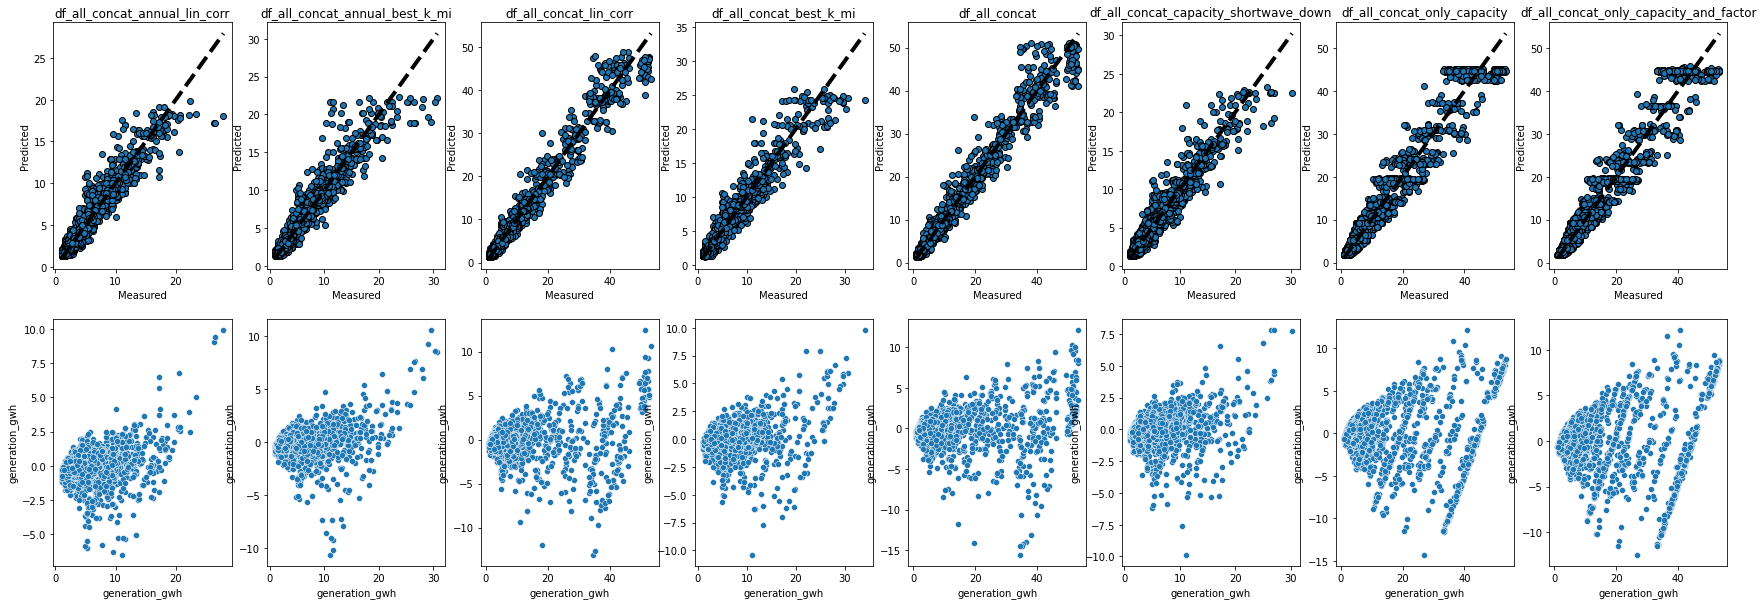

In [69]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    # predicted = cross_val_predict(rf_grid.best_estimator_, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    predicted = cross_val_predict(rf_model, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()
    
    residuals = df_X_y['y_train'] - predicted
    dataframes_dict_X_y[k]['predictions'] = predicted
    dataframes_dict_X_y[k]['residuals'] = residuals
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

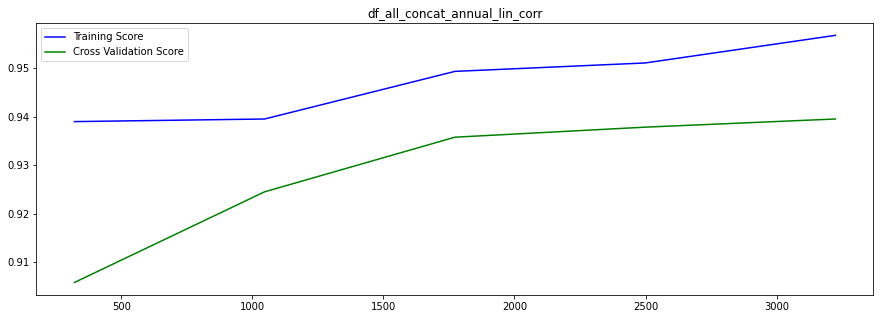

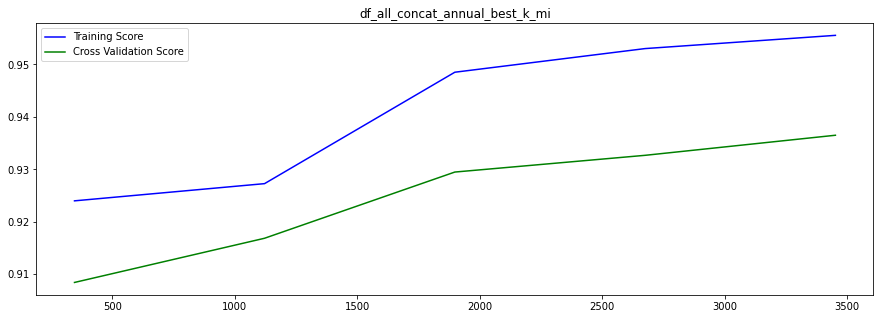

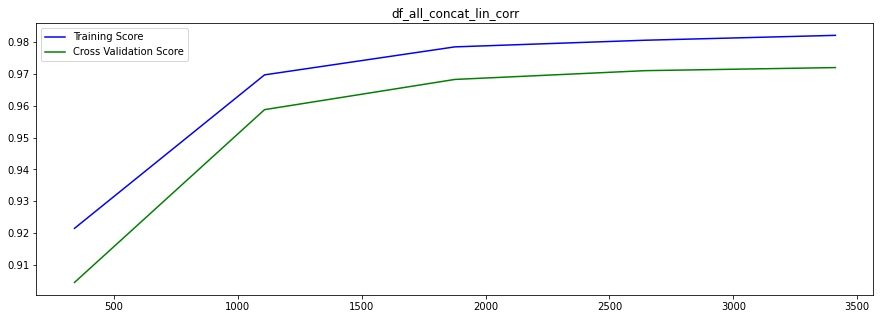

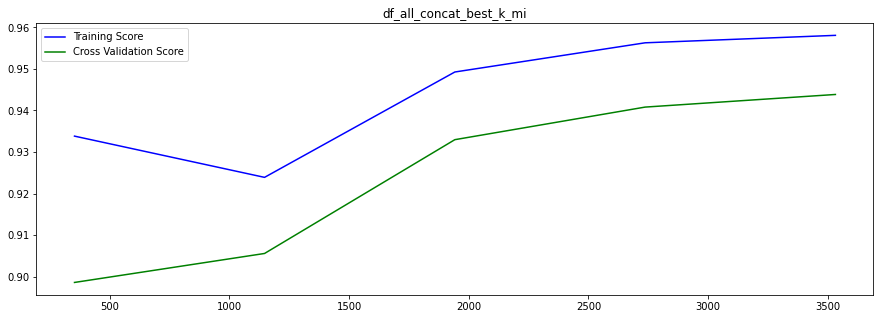

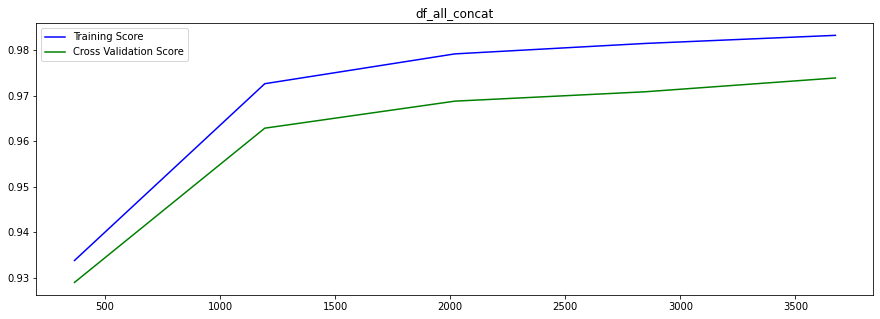

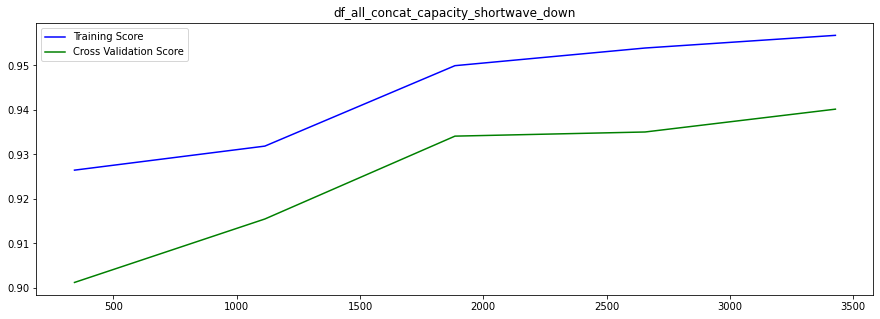

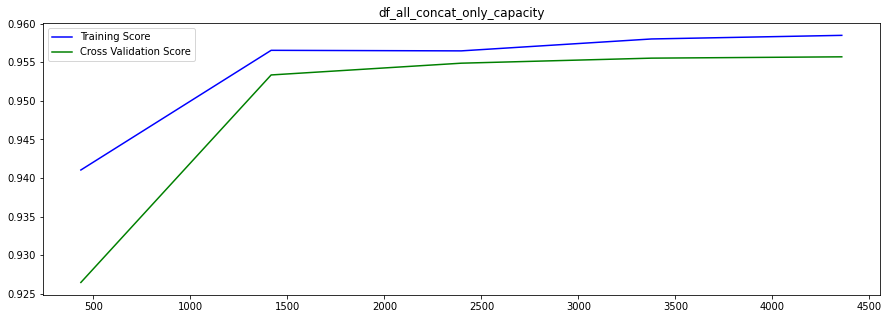

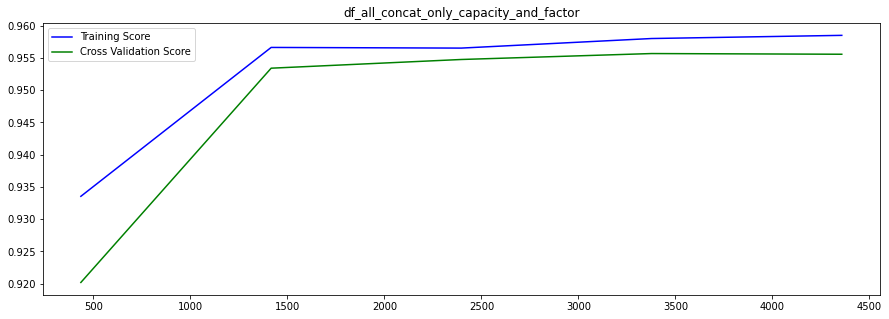

In [70]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    learning_curve_plot(k, rf_model,df_X_y['X_train'], df_X_y['y_train'])

In [ ]:
residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['residuals'].reset_index()
residuals_original = dataframes_dict_X_y['df_all_concat_lin_corr']['residuals']

In [ ]:
residuals

In [ ]:
residuals['index']

In [ ]:
residuals[residuals == residuals.quantile(.05, interpolation='lower')].values

In [ ]:
lowq = float(residuals['generation_gwh'][residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.05, interpolation='lower')].values)
lowq_index_pred = residuals[residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.05, interpolation='lower')].index
lowq_index = residuals[residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.05, interpolation='lower')]['index']

In [ ]:
higq = float(residuals['generation_gwh'][residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.95, interpolation='lower')].values)
higq_index_pred = residuals[residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.95, interpolation='lower')].index
higq_index = residuals[residuals['generation_gwh'] == residuals['generation_gwh'].quantile(.95, interpolation='lower')]['index']

In [ ]:
print(lowq) 
print(higq) 
print(lowq_index) 
print(higq_index) 
print(lowq_index_pred) 
print(higq_index_pred) 

In [ ]:
# dataframes_dict_X_y['df_all_concat_lin_corr']['predictions'][lowq_index]

In [ ]:
# Generating the error distribution
# resid_oob = dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'] - rf_model_2.oob_prediction_
# residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['residuals']
# residuals[residuals == residuals.quantile(.05, interpolation='lower')]
# 50% interval
lowq = residuals.quantile(0.05)
# lowq_index = residuals.index(residuals.quantile(0.05))
higq = residuals.quantile(0.95)
# higq_index = residuals.index(residuals.quantile(0.95))
print(lowq) 
print(higq) 
# negative much larger
# so tends to overpredict time

In [ ]:
# Generating predictions on out of sample data
y_pred = rf_model_2.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
lowt = (y_pred + lowq).clip(0) #cant have negative numbers
higt = (y_pred + higq)

cover = (dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'] >= lowt) & (dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'] <= higt)
print(cover.mean())

In [ ]:
residuals.hist(bins=100)

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'][lowq_index]

In [ ]:
residuals.sort_values()

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'][lowq_index]

In [ ]:
fig = plt.figure(figsize=(30, 15))
# point1 = [0,0]
# point2 = [dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'][lowq_index].values, dataframes_dict_X_y['df_all_concat_lin_corr']['predictions'][lowq_index_pred]]
# order = np.argsort(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values)
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], f(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values,  y_pred, "b.", markersize=10, label="Test observations")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values,  lowt, "r*", markersize=10, label="")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values,  higt, "k*", markersize=10, label="")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['mid'], "r-", label="Predicted mean")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions, "r-", label="Predicted mean")
# plt.plot([point1[0], point2[0]], [point1[1], point2[1]])
# plt.plot(0, higq_oob, "r*")
# plt.fill_between(
#     dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values.ravel(), predictions['lower'], predictions['upper'], alpha=0.4, label="Predicted 90% interval"
# )
# plt.xlabel("$x$")
# plt.ylabel("$f(x)$")
# plt.ylim(-10, 25)
# plt.legend(loc="upper left")
plt.show()

In [ ]:
example_1 =dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'].sample(1)

In [ ]:
example_1_modif = example_1.copy()

example_1_modif
# example_1_modif = example_1['capacity']

In [ ]:
example_1_modif['capacity_mw'] = 20.0

In [ ]:
mp = rf_model_2.predict(example_1_modif)
print(mp)
print( (mp-lowq).clip(0), (mp+higq) )

# LASSO, RIDGE, LINEAR REGRESSION

In [ ]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

ridge_model = Ridge(alpha=1)
ridge_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

linreg_model = LinearRegression()
linreg_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

y_pred = lasso_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Lasso")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(lasso_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']))

y_pred = linreg_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Linear Regression")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(linreg_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
)
y_pred = ridge_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Ridge")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(ridge_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']))

In [ ]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(Lasso(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])


In [ ]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(Ridge(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(LinearRegression(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
np.arange(0.01, 1.01, 0.01)

In [ ]:
# generamos 50 lambdas para evaluar los distintos escenarios
n_alphas = 50
alphas = np.logspace(1.5, 7.2, n_alphas)

# Ajustamos  la regresion Lasso para los disntos valores de lambda que establecimos
coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False)
    lasso.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
    coefs.append(lasso.coef_)

In [ ]:
#Graficamos como varian las variables cuando se aumenta el lambda

fig, ax = plt.subplots(figsize=(10,7))

l1 = plt.plot(alphas, coefs,linewidth=2 )

ax.set_title('Regularización Lasso', fontweight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('coeficientes', fontsize=10)
ax.set_xlabel('Log(lambda)', fontsize=10)

plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )
plt.show()

In [ ]:

# Nos quedamos con las variables que sobreviven al proceso de selección
coeficientes = pd.DataFrame(coefs, columns =dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'].columns)

variables_importantes = coeficientes.loc[:,dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'].columns[coeficientes.loc[45:].any().values]]

In [ ]:

# Graficamos nuevamente
fig, ax = plt.subplots(figsize=(10,7))

l1 = plt.plot(alphas, variables_importantes,linewidth=2 )

ax.set_title('Regularización Lasso', fontweight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(coeficientes.columns, fontsize=10)
ax.set_ylabel('coeficientes', fontsize=10)
ax.set_xlabel('Log(lambda)', fontsize=10)

plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

plt.show()

# SCALLING

In [ ]:

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):    
    # X_train_normalized = stats.boxcox(X_train)
    x = df_X_y['X_train'].values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    power_transformer = PowerTransformer(method='yeo-johnson')
    standard_scaler = StandardScaler()
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_train_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X_train'].index, columns=df_X_y['X_train'].columns)

    x = df_X_y['X_test'].values #returns a numpy array
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_test_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X_test'].index, columns=df_X_y['X_test'].columns)

    x = df_X_y['X'].values #returns a numpy array
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X'].index, columns=df_X_y['X'].columns)


# KNN

In [ ]:
candidate_n_neighbors = np.arange(1,31)

# plt.figure(figsize=(25,15))
fig, ax =plt.subplots(1,len(dataframes_dict_X_y), figsize=(15,5))
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = {}
    results = {node: utils.get_accuracy_knn("regression",node, df_X_y['X_train_scaled'], df_X_y['X_test_scaled'], df_X_y['y_train'], df_X_y['y_test']) for node in candidate_n_neighbors}
    best_n_neighbors = max(results, key=results.get)
    print(f'{k} best_n_neighbors: {best_n_neighbors}')
    dataframes_dict_X_y[k]['best_n_neighbors'] = best_tree_size
    ax[i].set_title(k)
    sns.lineplot(data=results, x= results.keys(), y= results.values(), ax=ax[i])

# results = {}

# # results = {n: utils.get_accuracy_knn(n, X_train_scaled_pca, X_test_scaled_pca, y_train, y_test) for n in candidate_n_neighbors}
# results = {n: utils.get_accuracy_knn("regression",n, X_train, X_test, y_train, y_test) for n in candidate_n_neighbors}
# best_n_neighbors = max(results, key=results.get)
# print(best_n_neighbors)
# sns.lineplot(data=results, x= results.keys(), y= results.values())

# POLYNOMIAL FEATURES

In [ ]:
polynomial_features = PolynomialFeatures(2)
polynomial_features.fit_transform(X)

In [ ]:
model_scaled_poly_knn = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(2),
    KNeighborsRegressor(n_neighbors = dataframes_dict_X_y['df_all_concat_lin_corr']['best_n_neighbors'])
)

model_scaled_poly_knn.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
model_scaled_poly_knn.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
y_pred = model_scaled_poly_knn.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'] - y_pred
# ap_residuals = np.abs(residuals) / y_test
# lap_residuals = np.log(ap_residuals)

y_pred = model_scaled_poly_knn.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
sns.scatterplot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], residuals)

In [ ]:
results = cross_validate(KNeighborsRegressor(n_neighbors = 12), X, y, cv=5)
results

# VALIDATION AND LEARNING CURVE
https://scikit-learn.org/stable/modules/learning_curve.html

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    validation_curve_plot(k, KNeighborsRegressor(), df_X_y['X_train_scaled'], df_X_y['y_train'], 'n_neighbors', np.array(candidate_n_neighbors))

In [ ]:
# train_scores, test_scores = validation_curve(
#     KNeighborsRegressor(),
#     X_train,
#     y_train,
#     param_name = "n_neighbors",
#     param_range = candidate_n_neighbors,
#     cv = 5
# )

In [ ]:
# np.mean(train_scores, axis=1)

In [ ]:
# candidate_n_neighbors.shape[0]

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    validation_curve_plot(k, KNeighborsRegressor(), df_X_y['X_train'], df_X_y['y_train'], 'n_neighbors', np.array(candidate_n_neighbors))

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    learning_curve_plot(k, KNeighborsRegressor(n_neighbors=14),df_X_y['X_train'], df_X_y['y_train'])

In [ ]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(KNeighborsRegressor(n_neighbors=14), df_X_y['X_train_scaled'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(KNeighborsRegressor(n_neighbors=14), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    # results = performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], rf_grid.best_estimator_, k)
    results = performance_metrics_cross_val(df_X_y['X_train_scaled'], df_X_y['y_train'], KNeighborsRegressor(n_neighbors = 14), k)
    print(k)
    print(results)

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors = 14)
knn_model.fit(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_train'], dataframes_dict_X_y['df_all_concat_best_k_mi']['y_train'])
y_pred = knn_model.predict(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_test'])
residuals = dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'] - y_pred
# ap_residuals = np.abs(residuals) / y_test
# lap_residuals = np.log(ap_residuals)
adjusted_r2(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_train'], dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], y_pred)
print(r2_score(dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], y_pred))
# y_pred = model_poly_knn.predict(X_test)
sns.scatterplot(dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], residuals)

In [ ]:

print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'], y_pred))
print(np.sqrt(mean_squared_error(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'], y_pred)))

# PREDICTION INTERVALS
https://mapie.readthedocs.io/en/latest/tutorial_regression.html
https://andrewpwheeler.com/2022/02/04/prediction-intervals-for-random-forests/
https://stats.stackexchange.com/questions/85560/shape-of-confidence-interval-for-predicted-values-in-linear-regression
https://saattrupdan.github.io/2020-03-01-bootstrap-prediction/
https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb

## Intervals with Gradient Tree Boosting

In [ ]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [int(x) for x in np.arange(10, 501, 10)]
# Minimum numbers of samples required to split a node
min_samples_split = [int(x) for x in np.arange(10, 51, 10)]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(5, 101, 5)]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

max_leaf_nodes = [int(x) for x in np.arange(10, 501, 10)]

learning_rate = [np.around(x,3) for x in np.arange(0.005, 2.001, 0.005)]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                # 'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes,
                'learning_rate': learning_rate
            }



In [ ]:
gbr_grid = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = param_grid, n_iter = 30, cv=5, verbose = 2, n_jobs=4)

In [ ]:
gbr_grid.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid.best_estimator_

In [ ]:
gbr_grid.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

In [ ]:
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

In [ ]:
neg_mean_pinball_loss_05p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=LOWER_ALPHA,
    greater_is_better=False,  # maximize the negative loss
)
neg_mean_pinball_loss_95p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=UPPER_ALPHA,
    greater_is_better=False,  # maximize the negative loss
)

In [ ]:
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

param_grid_lower = param_grid.copy()
# param_grid_lower['loss'] = 'quantile'
# param_grid_lower['alpha'] = LOWER_ALPHA

param_grid_upper = param_grid.copy()
# param_grid_upper['loss'] = 'quantile'
# param_grid_upper['alpha'] = UPPER_ALPHA

### Lower

In [ ]:
gbr_grid_lower = RandomizedSearchCV(estimator = GradientBoostingRegressor(loss='quantile', alpha=LOWER_ALPHA), param_distributions = param_grid_lower, n_iter = 30, cv=5, verbose = 2, n_jobs=4, scoring=neg_mean_pinball_loss_05p_scorer)

In [ ]:
gbr_grid_lower.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid_lower.best_estimator_

In [ ]:
gbr_grid_lower.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

### Upper

In [ ]:
gbr_grid_upper = RandomizedSearchCV(estimator = GradientBoostingRegressor(loss='quantile', alpha=UPPER_ALPHA), param_distributions = param_grid_upper, n_iter = 30, cv=5, verbose = 2, n_jobs=4, scoring=neg_mean_pinball_loss_95p_scorer)

In [ ]:
gbr_grid_upper.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid_upper.best_estimator_

In [ ]:
gbr_grid_upper.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

In [ ]:
# Set lower and upper quantile


# N_ESTIMATORS = 100
# MAX_DEPTH = 5

# Each model has to be separate
GradientBoostingRegressor(alpha=0.05, learning_rate=0.385, loss='quantile',
                          max_depth=260, max_leaf_nodes=430,
                          min_samples_leaf=50, min_samples_split=20,
                          n_estimators=60)
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA, learning_rate=0.245, max_depth=430,
                          max_leaf_nodes=300, min_samples_leaf=10,
                          min_samples_split=20, n_estimators=70)
# The mid model will use the default
# mid_model = GradientBoostingRegressor(learning_rate=0.245, max_depth=430,
#                           max_leaf_nodes=300, min_samples_leaf=10,
#                           min_samples_split=20, n_estimators=70)
mean_model = GradientBoostingRegressor(learning_rate=0.245, max_depth=430,
                          max_leaf_nodes=300, min_samples_leaf=10,
                          min_samples_split=20, n_estimators=70)
# mid_model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

upper_model = GradientBoostingRegressor(alpha=0.95, learning_rate=0.155, loss='quantile',
                          max_depth=350, max_leaf_nodes=320,
                          min_samples_leaf=60, min_samples_split=30,
                          n_estimators=90)

In [ ]:
_ = lower_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
_ = mid_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
_ = upper_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
predictions = pd.DataFrame(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
predictions['lower'] = lower_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['mid'] = mid_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['upper'] = upper_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['mean'] = mean_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])


# assert (predictions['upper'] > predictions['lower']).all()

predictions.tail()

In [ ]:
predictions['upper'] > predictions['lower']

In [ ]:
predictions[(predictions['lower'] > predictions['upper'])]

In [ ]:
predictions[(predictions['lower'] > predictions['mid'])].count()

In [ ]:
predictions[(predictions['mid'] > predictions['upper'])].count()

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'][7491]

In [ ]:
fig = plt.figure(figsize=(30, 15))

# order = np.argsort(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values)
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], f(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values,  predictions['mid'], "b.", markersize=10, label="Test observations")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['mid'], "r-", label="Predicted mean")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions, "r-", label="Predicted mean")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['upper'], "k*")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['lower'], "r*")
# plt.fill_between(
#     dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values.ravel(), predictions['lower'], predictions['upper'], alpha=0.4, label="Predicted 90% interval"
# )
# plt.xlabel("$x$")
# plt.ylabel("$f(x)$")
# plt.ylim(-10, 25)
# plt.legend(loc="upper left")
plt.show()

In [ ]:
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))


coverage_fraction(
    dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'],
    lower_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']),
    upper_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']),
)

In [ ]:
order

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values[order]

In [ ]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    # predicted = cross_val_predict(rf_grid.best_estimator_, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    predicted = cross_val_predict(mid_model, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    learning_curve_plot(k, mid_model,df_X_y['X_train'], df_X_y['y_train'])

In [ ]:
rf_model = rf_grid.best_estimator_
# XX, yy = make_regression(n_samples=500, n_features=1, noise=20, random_state=59)

In [ ]:
rf_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
predictions_try = rf_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])

predictions_try

## Intervals with Mapie

In [ ]:
def plot_1d_data(
    X_train,
    y_train,
    y_pred_low,
    y_pred_up,
    ax=None,
    title=None
):
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_xlabel("x") ; ax.set_ylabel("y")
    # ax.fill_between(X_train, y_pred_low, y_pred_up, alpha=0.3)
    ax.scatter(X_train, y_train, color="red", alpha=0.3, label="Training data")
    ax.plot(X_train, y_pred_low, color="gray", ls="--", label="Lower")
    # ax.plot(X_test, y_test - y_sigma, color="gray", ls="--")
    # ax.plot(X_test, y_test + y_sigma, color="gray", ls="--")
    ax.plot(X_train, y_pred_up, color="blue", ls="--", alpha=0.5, label="Upper")
    ax.plot(X_train, X_train, color="black", ls="-", alpha=0.5, label="Real target")
    if title is not None:
        ax.set_title(title)
    ax.legend()

In [ ]:
alpha = 0.05
# mapie = MapieRegressor(rf_model, method="plus", cv=5)
# mapie = MapieRegressor(rf_model, method="naive")
# mapie = MapieRegressor(rf_model, method="base", cv=-1)
# mapie = MapieRegressor(rf_model, method="minmax", cv=10)
mapie = MapieRegressor(rf_model, method="base", cv=5)
mapie.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
y_pred, y_pis = mapie.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], alpha=alpha)


In [ ]:
df_mapie = pd.DataFrame()
df_mapie['y_pred'] = y_pred
df_mapie['y_test'] = dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].reset_index(drop=True)
df_mapie['y_pis_lower'] = y_pis[:,0,:]
df_mapie['y_pis_upper'] = y_pis[:,1,:]
df_mapie_sorted = df_mapie.sort_values(by=['y_test'])

In [ ]:
# fig, ax = plt.subplots(figsize=(10,7))

# order = np.argsort(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values)
plot_1d_data(
    df_mapie_sorted['y_test'],
    df_mapie_sorted['y_pred'],
    df_mapie_sorted['y_pis_lower'],
    df_mapie_sorted['y_pis_upper'],
    ax=None,
    title=None
)

In [ ]:
alpha = 0.05
# mapie = MapieRegressor(rf_model, method="plus", cv=5)
# mapie.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
# y_pred, y_pis = mapie.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], alpha=alpha)


mapie = MapieQuantileRegressor(GradientBoostingRegressor(loss="quantile", learning_rate=0.245, max_depth=430,
                          max_leaf_nodes=300, min_samples_leaf=10,
                          min_samples_split=20, n_estimators=70), method="quantile", cv="split", alpha=alpha)
mapie.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
y_pred, y_pis = mapie.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])

In [ ]:
df_mapie = pd.DataFrame()
df_mapie['y_pred'] = y_pred
df_mapie['y_test'] = dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].reset_index(drop=True)
df_mapie['y_pis_lower'] = y_pis[:,0,:]
df_mapie['y_pis_upper'] = y_pis[:,1,:]
df_mapie_sorted = df_mapie.sort_values(by=['y_test'])

In [ ]:
plot_1d_data(
    df_mapie_sorted['y_test'],
    df_mapie_sorted['y_pred'],
    df_mapie_sorted['y_pis_lower'],
    df_mapie_sorted['y_pis_upper'],
    ax=None,
    title=None
)

In [ ]:
coverage_scores = [
    regression_coverage_score(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'], y_pis[:, 0, i], y_pis[:, 1, i])
    for i, _ in enumerate(alpha_sasa)
]

In [ ]:
order = np.argsort(XX[:, 0])
# dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test']

In [ ]:

plt.xlabel("x")
plt.ylabel("y")
order = np.argsort(XX[:, 0])
plt.scatter(XX[order], y_pred_sasa[order], alpha=0.3)
plt.plot(XX[order], y_pred_sasa[order], color="C1")
plt.plot(XX[order], y_pis[order][:, 0, 1], color="C1", ls="--")
plt.plot(XX[order], y_pis[order][:, 1, 1], color="C1", ls="--")
plt.fill_between(
    XX[order].ravel(),
    y_pis[order][:, 0, 0].ravel(),
    y_pis[order][:, 1, 0].ravel(),
    alpha=0.2
)
plt.title(
    f"Target and effective coverages for "
    f"alpha={alpha_sasa[0]:.2f}: ({1-alpha_sasa[0]:.3f}, {coverage_scores[0]:.3f})\n"
    f"Target and effective coverages for "
    f"alpha={alpha_sasa[1]:.2f}: ({1-alpha_sasa[1]:.3f}, {coverage_scores[1]:.3f})"
)
plt.show()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_model = Lasso(alpha=0.05)
res = []
estimators = []
for train_index, test_index in kf.split(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train']):
    # continue
    # print(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[train_index])
    X_train_, X_test_ = dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[train_index], dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[test_index]
    y_train_, y_test_ = dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_train'].iloc[train_index], dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_train'].iloc[test_index]
    
    lasso_model.fit(X_train_, y_train_)
    estimators.append(lasso_model)
    res.extend(list(y_test_ - lasso_model.predict(X_test_)))

In [ ]:
plt.xlabel("x")
plt.ylabel("y")
order = np.argsort(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values)
plt.scatter(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], y_pred[order], alpha=0.3)
plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], y_pred[order], color="C1")
# plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], y_pis[order][:, 0, 1], color="C1", ls="--")
# plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], y_pis[order][:, 1, 1], color="C1", ls="--")
plt.fill_between(
    dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order].ravel(),
    y_pis[order][:, 0, 0].ravel(),
    y_pis[order][:, 1, 0].ravel(),
    alpha=0.2
)
# plt.title(
#     f"Target and effective coverages for "
#     f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_scores[0]:.3f})\n"
#     f"Target and effective coverages for "
#     f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_scores[1]:.3f})"
# )
plt.show()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_model = Lasso(alpha=0.05)
res = []
estimators = []
for train_index, test_index in kf.split(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train']):
    # continue
    # print(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[train_index])
    X_train_, X_test_ = dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[train_index], dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train'].iloc[test_index]
    y_train_, y_test_ = dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_train'].iloc[train_index], dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_train'].iloc[test_index]
    
    knn_model.fit(X_train_, y_train_)
    estimators.append(knn_model)
    res.extend(list(y_test_ - knn_model.predict(X_test_)))


In [ ]:
y_pred_multi = np.column_stack([e.predict(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_test']) for e in estimators])

In [ ]:
alpha = 0.05
ci = np.quantile(res, 1 - alpha)
top = []
bottom = []
for i in range(y_pred_multi.shape[0]):
    if ci > 0:
        top.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
    else:
        top.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))

In [ ]:
preds = np.median(y_pred_multi, axis=1)
df = pd.DataFrame()
df['pred'] = preds
df['upper'] = top
df['lower'] = bottom

In [ ]:
df.sort_values(['upper'], ascending = False)


In [ ]:
# df.sort_values(['pred'], ascending = False)
df.iloc[702,:]

In [ ]:
dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].iloc[702]
dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].count()

In [ ]:
def generate_plot_plus(y_test, preds, bottom, upper,):
    
    ci_pack = np.vstack([bottom, upper])
    
    plt.figure(figsize=(12,9))
    plt.errorbar([i for i in range(len(preds))], preds, ci_pack, fmt='o', color='black', ecolor='lightgray')
    plt.plot([i for i in range(len(y_test))], y_test, 'o', c='r')
    plt.legend(['True Value', 'Prediction', 'Confidence Interval'])
    plt.show()

In [ ]:

order = np.argsort(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values)
# generate_plot_plus(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], df['pred'].values[order], df['lower'].values[order], df['upper'].values[order])
generate_plot_plus(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'], df['pred'], df['lower'], df['upper'])

In [ ]:
fig, ax = plt.subplots()

order = np.argsort(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values)
ax.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], df['pred'][order], color="C1")
ax.scatter(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order],df['pred'].values[order])
ax.fill_between(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], df['lower'].values[order].ravel(), df['upper'].values[order].ravel(), color='b', alpha=.1)

In [ ]:

# plt.xlabel("x")
# plt.ylabel("y")
plt.scatter(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], df['pred'].values[order], alpha=0.3)
plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order], df['pred'].values[order], color="C1")
# order = np.argsort(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_test'][:, 0])
# plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_test'][order], y_pis[order][:, 0, 1], color="C1", ls="--")
# plt.plot(dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_test'][order], y_pis[order][:, 1, 1], color="C1", ls="--")
plt.fill_between(
    dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['y_test'].values[order].ravel(),
    df['lower'].values[order].ravel(),
    df['upper'].values[order].ravel(),
    alpha=0.2
)
plt.title(
    f"Target and effective coverages for "
    f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_scores[0]:.3f})\n"
    f"Target and effective coverages for "
    f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_scores[1]:.3f})"
)
plt.show()

In [ ]:
dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['y_test'].describe()

## Quantile Regressor on between y real values and y predicted values

<AxesSubplot:xlabel='generation_gwh', ylabel='generation_gwh'>

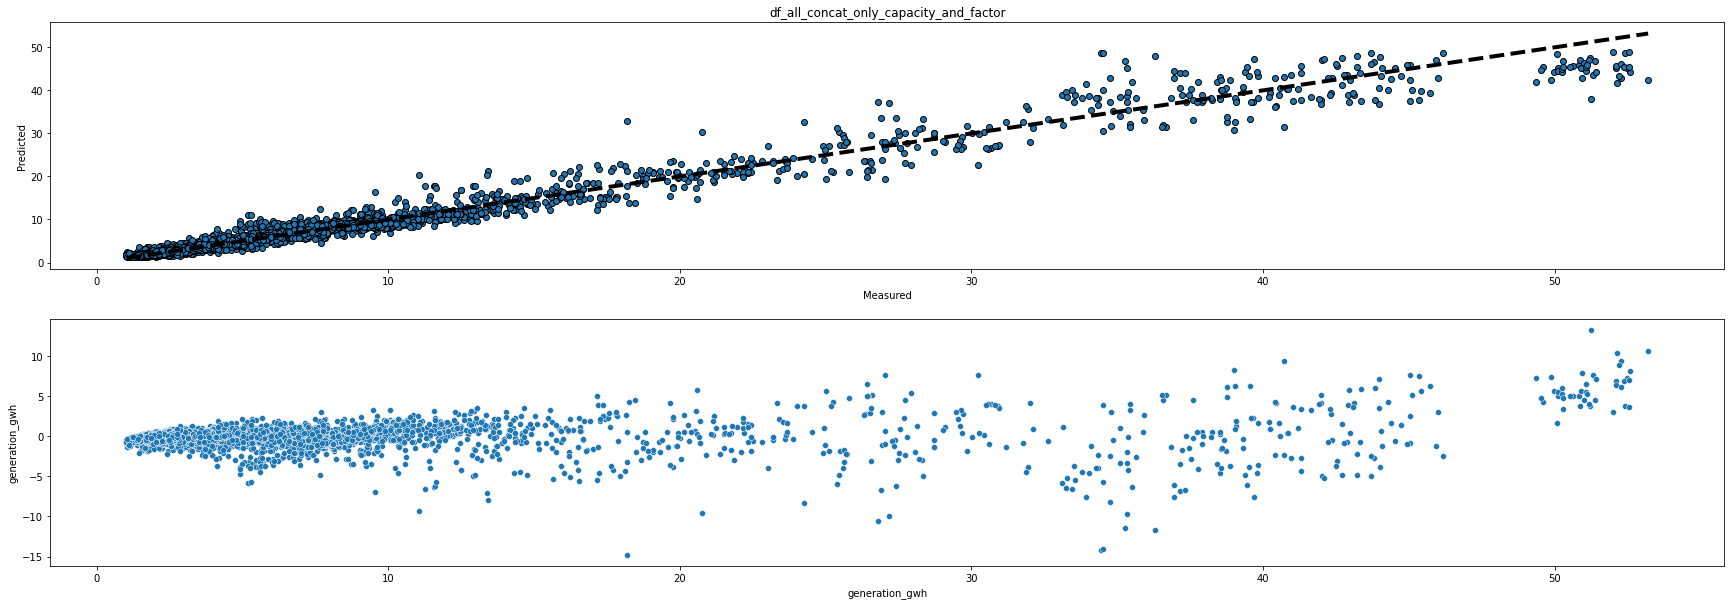

In [71]:

fig, ax =plt.subplots(2, figsize=(30,10))

# for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
# predicted = cross_val_predict(rf_grid.best_estimator_, df_X_y['X_train'], df_X_y['y'], cv=5)
predicted = cross_val_predict(rf_model, dataframes_dict_X_y['df_all_concat_lin_corr']['X'], dataframes_dict_X_y['df_all_concat_lin_corr']['y'], cv=5)
# fig, ax = plt.subplots()
ax[0].scatter(dataframes_dict_X_y['df_all_concat_lin_corr']['y'], predicted, edgecolors=(0, 0, 0))
ax[0].plot([dataframes_dict_X_y['df_all_concat_lin_corr']['y'].min(), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].max()], [dataframes_dict_X_y['df_all_concat_lin_corr']['y'].min(), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].max()], "k--", lw=4)
ax[0].set_xlabel("Measured")
ax[0].set_ylabel("Predicted")
ax[0].set_title(k)
# plt.show()

residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['y'] - predicted
dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'] = predicted
sns.scatterplot(x=dataframes_dict_X_y['df_all_concat_lin_corr']['y'], y=residuals, ax=ax[1])

In [72]:
dataframes_dict_X_y['df_all_concat_lin_corr']['predictions']

array([ 7.19730936,  9.36221085, 15.40656135, ...,  4.43852861,
        9.21267149,  2.00691352])

In [73]:
quantiles = [0.05, 0.95]
predictions_qr = {}
# dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data']
# dataframes_dict_X_y['df_all_concat_lin_corr']['y']
out_bounds_predictions = np.zeros_like(dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, fit_intercept= False, solver='highs', alpha=0)
    qr.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'].reshape(-1, 1), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values)
    dataframes_dict_X_y['df_all_concat_lin_corr'][f'model_qr_{str(quantile)[2:]}_fit'] = qr
    y_pred = qr.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'].reshape(-1, 1))
    predictions_qr[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values
        )

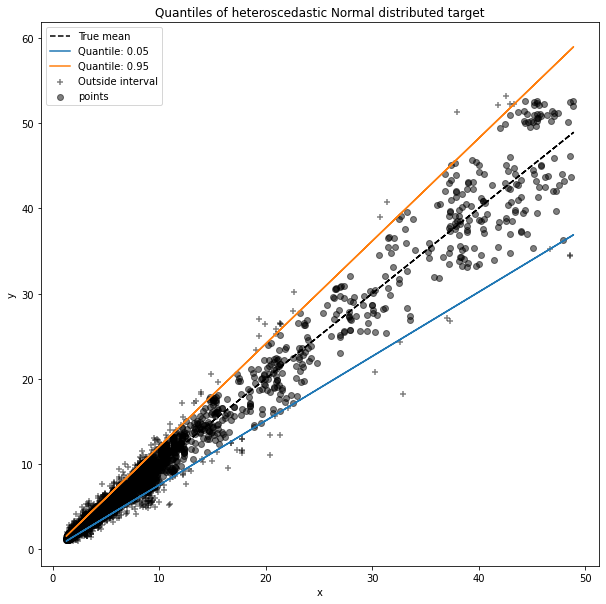

In [74]:
plt.figure(figsize=(10,10))

# dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data']
# dataframes_dict_X_y['df_all_concat_lin_corr']['y']

plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions_qr.items():
    plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'][out_bounds_predictions],
    dataframes_dict_X_y['df_all_concat_lin_corr']['y'][out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)

plt.scatter(
    dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'][~out_bounds_predictions],
    dataframes_dict_X_y['df_all_concat_lin_corr']['y'][~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="points",
)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

In [75]:
dataframes_dict_X_y['df_all_concat_lin_corr'].keys()

dict_keys(['X', 'y', 'X_train', 'X_test', 'y_train', 'y_test', 'best_tree_size', 'predictions', 'residuals', 'predictions_all_data', 'model_qr_05_fit', 'model_qr_95_fit'])

In [78]:
dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_05_fit'].predict(np.array([[50]]))

array([37.71673852])

In [79]:
dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_95_fit'].predict(np.array([[50]]))

array([60.2578451])

In [80]:
out_bounds_predictions.sum()


697

In [82]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y'].count() / (dataframes_dict_X_y['df_all_concat_lin_corr']['y'].count() + out_bounds_predictions.sum())

0.8843921048266711

In [ ]:
df_mapie['y_test'].values.reshape(-1, 1)

In [ ]:
df_mapie['y_test']

In [ ]:
df_mapie['y_pred'] = y_pred
df_mapie['y_test'] = dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].reset_index(drop=True)
df_mapie['y_pis_lower'] = y_pis[:,0,:]
df_mapie['y_pis_upper'] = y_pis[:,1,:]

# EXPORTING THE MODEL

In [84]:
# rf_model = rf_grid.best_estimator_
rf_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X'], dataframes_dict_X_y['df_all_concat_lin_corr']['y'])
joblib.dump(rf_model, utils.DIR_MODELS/"rf_model_regressor.pkl")
joblib.dump(dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_05_fit'], utils.DIR_MODELS/"qr_model_05.pkl")
joblib.dump(dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_95_fit'], utils.DIR_MODELS/"qr_model_95.pkl")


['/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/models/qr_model_95.pkl']

In [ ]:
dataframes_dict_X_y['df_all_concat_capacity_shortwave_down']['X_train']['capacity_mw'].describe()